# Coursework Assignment: Building a Regression Model

```
University of London
BSc in Computer Science
CM3005, Data Science
Hudson Leonardo MENDES
hlm12@student.london.ac.uk
```


# I. Introduction


## Domain-specific area

Banks and Credit Institutions are often required to assess the values of properties in their portfolios by policymakers, concerned about their solvency, given that the collateral to the mortgages they trade are essentially properties themselves[[1](#ref:2007:hjort-et-al)]. However, Pension Funds[[2](#ref:2022:rastegar)] or any other company or person investing in real estate can benefit from understanding where the market trends are more likely heading.

The updated property prices must be predicted frequently and are traditionally processed using a system commercially known as an "Automated Valuation Model" (or AVM)[[1](#ref:2007:hjort-et-al), [3](#ref:web:rightmove-avm)]. These are either (a) a hedonic regression model, that regresses the transaction price from the set of features intrinsic to the property (e.g. the number of bedrooms), (b) a model focusing on repeated sales of the same property, to understand the price variations of the same object, (c) a hybrid model using features from both approaches, or (d) models including spatial methods [[1](#ref:2007:hjort-et-al)].

Hedonic regression relies on variables mapped to property prices linearly, and "the linear assumption can be unrealistic"[[1](#ref:2007:hjort-et-al)]. Recently Neural Networks have been suggested as an alternative for House Price Forecasting that resulted in a 1% Average Relative Root Mean Square Error across one hundred cities in China[[4](#ref:2021:xu-et-al)], perhaps suggesting the ability to break the linearity is a relevant component in house price predictions.

The present work presents two hedonic regression models, the first based on Polynomial Regression, and the second based on Multi-layer Perceptron Regression, both regressing property prices from intrinsic features of these properties, trained on the Price Paid Data[[5](#ref:web:uk-land-registry)] provided by the HM Land Registry in the United Kingdom.


## Dataset

To build a property price regressor, data related to property transactions was collected. The UK HM Land Registry department provides a high-quality dataset in CSV format called **Price Paid Data**[[5](#ref:web:uk-land-registry)], containing information such as the date of the transaction, and the type of the property, which looked, at first, relevant data to feed into a hedonic regressor.

Additionally, extra data was collected for information that would intuitively seem to be strongly correlated to variation in property prices, such as the **Interest Rate over Time**[[6](ref:web:uk-boe-interest)] and the **Inflation Rate over Time**[[7](#ref:web:uk-ons-cpih)], both known to be connected to the purchasing power and, therefore, to demand.

> Contains HM Land Registry data © Crown copyright and database right 2021.<br />
> This data is licensed under the Open Government Licence v3.0.

### Real Estate Transaction History

#### Summary

| **Organisation** | HM Land Registry                                                                                                                                                                                                                                                                     |
| ---------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Name**         | Price Paid Data                                                                                                                                                                                                                                                                      |
| **Last Update**  | 31 November 2022                                                                                                                                                                                                                                                                     |
| **Source URL**   | https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads                                                                                                                                                                                                        |
| **License**      | [Open Government Licence (OGL)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)                                                                                                                                                                           |
| **File Format**  | 4 yearly consolidated `.csv` files (2018, 2019, 2020, 2021), each with approximately 120MB & 1 partial yearly `.csv` file (2022) with approximately 5MB. These were stored locally as zip files, which resulted in files under 30MB fit for being uploaded into a Github repository. |
| **Attributes**   | Price, Timestamp, Address, Property Type and other attributes, described in full in the schema section below.                                                                                                                                                                        |
| **Instances**    | 4,336,841 transactions                                                                                                                                                                                                                                                               |
| **Impurities**   | One property category `other` is too broad to provide signal for the regression, and therefore must be ignored. Also, entries with missing `postcodes` are insufficient for our modelling activities, therefore they must also be eliminated.                                        |

#### Schema

| **Column**            | **Dtype** | **Nature**  |
| --------------------- | :-------: | :---------: |
| **id**                |   uuid    |  numerical  |
| **price**             |  integer  |  numerical  |
| **date**              |  string   |    date     |
| **postcode**          |  string   | categorical |
| **property_type**     |  string   | categorical |
| **old_or_new**        |  string   | categorical |
| **duration**          |  object   | categorical |
| **paon**              |  object   |    text     |
| **saon**              |  object   |    text     |
| **street**            |  object   |    text     |
| **locality**          |  object   |    text     |
| **town_city**         |  object   |    text     |
| **district**          |  object   |    text     |
| **county**            |  object   | categorical |
| **ppd_category_type** |  object   | categorical |
| **record_status**     |  object   | categorical |

#### Missing Attribute Values

|              | **missing** |  **%** |
| ------------ | ----------: | -----: |
| **postcode** |      18,471 |   0.4% |
| **saon**     |   4,013,617 | 87.29% |
| **street**   |      86,816 |  1.89% |
| **locality** |   2,846,155 |  61.9% |

#### Unique Attribute Values

|                       | **uniques** |  **%** |
| --------------------- | ----------: | -----: |
| **id**                |   4,597,894 | 100.0% |
| **price**             |      96,000 |  2.09% |
| **date**              |       1,758 |  0.04% |
| **postcode**          |   1,044,446 | 22.72% |
| **property_type**     |           5 |   0.0% |
| **old_or_new**        |           2 |   0.0% |
| **duration**          |           2 |   0.0% |
| **paon**              |     243,571 |   5.3% |
| **saon**              |      30,493 |  0.66% |
| **street**            |     278,907 |  6.07% |
| **locality**          |      20,583 |  0.45% |
| **town_city**         |       1,151 |  0.03% |
| **district**          |         357 |  0.01% |
| **county**            |         115 |   0.0% |
| **ppd_category_type** |           2 |   0.0% |

### Interest Rate over Time

#### Summary

| **Organisation** | Bank of England                                                                                                                        |
| ---------------- | :------------------------------------------------------------------------------------------------------------------------------------- |
| **Name**         | Official Bank Rate history                                                                                                             |
| **Last Update**  | 20 December 2022                                                                                                                       |
| **Source URL**   | https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp                                                                         |
| **License**      | [UK Open Government Licence](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)                                |
| **File Format**  | 1 file in `.csv` format                                                                                                                |
| **Attributes**   | `Date changed` and `rate`                                                                                                              |
| **Instances**    | 582 instances                                                                                                                          |
| **Impurities**   | Only presents the "dates of change", so to know the tax in a given day, the dataset will have to be interpolated to a daily frequency. |

#### Schema

| **Column**       | **DType** | **Nature** |
| ---------------- | :-------: | :--------: |
| **Date changed** |    str    |    date    |
| **rate**         |   float   |   float    |

#### Missing Attribute Values

There are no missing values in this dataset

#### Unique Attribute Values

|          | **uniques** |  **%** |
| -------- | ----------: | -----: |
| **rate** |         114 | 46.15% |

### Inflation Rate over Time

#### Summary

| **Organisation** | Office for National Statistics                                                                                                                                                                                                                                                                                                                                       |
| ---------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Name**         | CPIH ANNUAL RATE 00: ALL ITEMS 2015=100                                                                                                                                                                                                                                                                                                                              |
| **Last Update**  | 20 December 2022                                                                                                                                                                                                                                                                                                                                                     |
| **Source URL**   | https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23                                                                                                                                                                                                                                                                                         |
| **License**      | [Open Government Licence (OGL)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)                                                                                                                                                                                                                                                           |
| **File Format**  | 1 file in `.csv` format                                                                                                                                                                                                                                                                                                                                              |
| **Attributes**   | `Title` containing the "date" and `CPIH ANNUAL RATE 00: ALL ITEMS 2015=100` containing the "rate"                                                                                                                                                                                                                                                                    |
| **Instances**    | 582 rows                                                                                                                                                                                                                                                                                                                                                             |
| **Impurities**   | (1) The file is not in tabular format, and some rows must be ignored; (2) the `Title` column contains the `date` of the rate change, but it is not in any standardised date format, so it must first be translated; (3) The `CPIH ANNUAL RATE 00: ALL ITEMS 2015=100` also contains non-numeric characters and invalid values (e.g.: `-`), which must be cleaned up. |

#### Schema

| **Column**                                  | **DType** | **Nature** |
| ------------------------------------------- | :-------: | :--------: |
| **Title**                                   |    str    |    date    |
| **CPIH ANNUAL RATE 00: ALL ITEMS 2015=100** |   float   |   float    |

#### Missing Attribute Values

|                                             | **missing** | **%** |
| ------------------------------------------- | ----------: | ----: |
| **CPIH ANNUAL RATE 00: ALL ITEMS 2015=100** |           7 |  1.2% |

#### Unique Attribute Values

|                                             | **uniques** |  **%** |
| ------------------------------------------- | ----------: | -----: |
| **date**                                    |         582 | 100.0% |
| **CPIH ANNUAL RATE 00: ALL ITEMS 2015=100** |          76 | 13.06% |


## Objectives

This document **aims** to produce a model that regresses the price for UK properties of type semi-detached, detached, flats and terraced, from variables such as the property type itself, if it is new or old, duration which can be either lease or freehold, as well as the inflation and interest rates.

Successfully achieving this **aim** would provide us with a model that could benefit decision-making based on UK property prices for present transactions, using information presently available at the time of the property purchase or sale, as well as for future transactions, provided that the model is fed with an accurate estimate of what the inflation and interest rate would be at the time of the transaction.

The **objectives** set out to pursue this aim are:

1. Observe the **correlation between continuous variables such as inflation rate, interest rate and price**. Intuition suggests that these variables should demonstrate some correlation, a hypothesis that shall become apparent when using an appropriate Data Visualisation technique. A high correlation between these variables is not required but might help to explain some price variation phenomena.

2. **Resolve the problem of sparsity and high-dimensionality of the dataset**, caused by the one-hot encoding of the postcode information that results in 2000+ sparse features, which asymptotically grows far too large in terms of time-complexity for any higher degree polynomial linear regression model to be trained. This problem shall be approached through _Feature Engineering_ and _Dimensionality Reduction_ and not _Feature Selection_, which could result in information loss, due to the sparsity of the features.

3. **Compare the MAPE metric between several different Polynomial Hedonic Regression and Multi-Perceptron Hedonic Regression models**, with several different hyperparameter settings, using sklearn's GridSearchCV. Literature shows that Neural Networks outperformed traditional and other ML approaches in predicting property price[[4](#ref:2021:xu-et-al)], a hypothesis that will be validated using the _Mean Absolute Percent Error (MAPE)_ metric. Additionally, we shall observe the _R2 score_ of the model to understand how well the input variables explain variance in the prediction.


# II. Implementation


## Preprocessing

The pre-processing step is responsible for **(a) loading the data** and **(b) transforming the data** until it is left in a tabular format containing the training matrix and the targets in the **1st Normal Form (1NF)**.

The **Price Paid Data (or "PPD")**[[5](#ref:web:uk-land-registry)] already comes in 1NF over several different .csv files. It is loaded into a single data frame, which is then expanded by concatenating the Inflation Rate and Interest Rate columns.

Post code information available PPD is too granular for modelling purposes. In some cases, a single building owns a postcode in the UK. Used as is, it would require far more data to produce a viable model. Feature Engineering is employed to produce a postal group feature that isn't just less granular, but also provides us with one that encodes some level of interpolated location for the property transactions.

The **Inflation Rate**[[6](ref:web:uk-boe-interest)] and **Interest Rate**[[7](#ref:web:uk-ons-cpih)] are indexed by their "date of change". Hence there is no rate data point available for every PPD transaction date. Interpolation therefore required for those datasets to ensure we have the rates for every PPD transaction record.


In [1]:
import pathlib

# determines the root folder for the data used in this project
data_folderpath = pathlib.Path("./data")

# folder path for Price Paid Data (UK Property Transaction History) with multiple csv files
ppd_folderpath = data_folderpath / "uk-ppd"

# file path for the inflation_rate data
inflation_filepath = data_folderpath / "uk-ons/ons-inflation-1989-2022.csv"

# file path for the interest_rate data
interest_filepath = data_folderpath / "uk-boe/boe-interest-1975-2022.csv"


In [2]:
import pandas as pd

# setup pandas dataframes to display float values with 3 decimal places
pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))


In [3]:
from tqdm import tqdm

# enables tqdm progress bar methods for pandas (progress_map, progress_apply)
tqdm.pandas()


### UK Property Transaction History (a.k.a. Price Paid Data)

The following routine transforms Price Paid Data into a normalised and filtered
data frame, containing only the features we want, including newly engineered
features, such as the `postgroup`.


In [4]:
from typing import Callable


# index `property_type` constant values to their corresponding descriptive names
ppd_property_type = {"D": "detached", "S": "semi-detached", "T": "terraced", "F": "flat/maisonettes"}

# index `duration` constant values to their corresponding descriptive names
ppd_duration = {"F": "freehold", "L": "leasehold"}

# index `old_or_new` constant values to their corresponding descriptive names
# The PPD data shows `Y` for new build properties and `N` for old build properties
ppd_old_or_new = {"Y": "new", "N": "old"}

# list (simpler) column names for the PPD data, based on the schema documentation, from:
# https://www.gov.uk/guidance/about-the-price-paid-data
ppd_cols_src = [
    "id",
    "price",
    "date",
    "postcode",
    "property_type",
    "old_or_new",
    "duration",
    "paon",
    "saon",
    "street",
    "locality",
    "town_city",
    "district",
    "county",
    "ppd_category_type",
    "record_status",
]

# list the output column names desired for the PPD data frame
ppdf_cols_dst = [
    "date",
    "postgroup",
    "property_type",
    "old_or_new",
    "duration",
    "price",
]

# list the PPD file names found in the PPD data folder
ppd_filepaths = list(ppd_folderpath.glob("*.zip"))

# concatenate all PPD files into a single data frame
ppd_df = pd.concat([pd.read_csv(fp, names=ppd_cols_src) for fp in tqdm(ppd_filepaths)])

# feature engineering: produces the `postgroup` feature from the `postcode` feature
# by splitting the postcodes into 2 groups by space. The first group is the postgroup.
# e.g.: W5 3QZ -> W5
ppd_df["postgroup"] = ppd_df["postcode"].progress_map(lambda x: str(x).split(" ")[0])

# ensures the datatypes of the `date` column is datetime
ppd_df["date"] = pd.to_datetime(ppd_df["date"])

# updates categorical features `property_type`, `duration`, and `old_or_new` to their
# actual descriptive names instead of the PPD constant values
ppd_df["property_type"] = ppd_df["property_type"].progress_map(ppd_property_type.get)
ppd_df["duration"] = ppd_df["duration"].progress_map(ppd_duration.get)
ppd_df["old_or_new"] = ppd_df["old_or_new"].progress_map(ppd_old_or_new.get)

# ensures the datatypes of the `price` column is float
ppd_df["price"] = ppd_df["price"].astype("float")

# filters the PPD data frame to only include the desired columns
ppd_df = ppd_df[ppdf_cols_dst]

# removes any rows with missing values
# this step removes on purpose transactions from the following situations:
# - propert_types not mapping to any of our target property types
# - rows with missing postcodes (hence missing postgroups)
# - records with missing values for any of the `ppdf_cols_dst` columns
ppd_df = ppd_df.dropna()

# ensures the datatypes of the `postgroup`, `property_type`, `old_or_new`, and `duration` columns are category
ppd_df = ppd_df.astype({c: "category" for c in ["postgroup", "property_type", "old_or_new", "duration"]})

# presents a sample of the pre-processed data frame.
ppd_df.sample(n=5)


100%|██████████| 4597894/4597894 [00:07<00:00, 652381.65it/s]


,date,postgroup,property_type,old_or_new,duration,price
905619,2018-08-24,CM8,semi-detached,old,freehold,"225,000.000"
671560,2020-06-16,WA2,flat/maisonettes,old,leasehold,"65,000.000"
804816,2020-08-05,TQ12,terraced,old,freehold,"138,000.000"
910347,2021-06-30,GL52,terraced,old,freehold,"315,000.000"
1082798,2021-02-19,WF5,semi-detached,old,freehold,"182,500.000"


### Inflation Rate Data

The following routine transforms the `inflation rate` data provided by the
**Office of National Statistics** into a normalised dataframe with correct datatypes
and clean values.


In [5]:
import re
import string
from datetime import date

# regex pattern to extract the year and month from the inflation_rate data
inflation_date_pattern = re.compile(r"([\d]{4})(?:\s+([\w]{3}))?")

# indexes the month names to their corresponding month index
# e.g.: JAN -> 1, FEB -> 2, ..., DEC -> 12
inflation_month_index = {
    mn: ix + 1
    for (ix, mn) in enumerate(
        [
            "JAN",
            "FEB",
            "MAR",
            "APR",
            "MAY",
            "JUN",
            "JUL",
            "AUG",
            "SEP",
            "OCT",
            "NOV",
            "DEC",
        ]
    )
}

# some datapoints present Q1, Q2, Q3, Q4 instead of the month names
# we map those to the first month of the quarter
inflation_month_index["Q1"] = 1
inflation_month_index["Q2"] = 4
inflation_month_index["Q3"] = 7
inflation_month_index["Q3"] = 10

# some rates are presented in invalid non-numerical format
# `inflation_acceptable_numeric_chars` is a list of acceptable characters
# so we can eliminate any rate that is not a number, thousand separator, or decimal separator
inflation_acceptable_numeric_chars = string.digits + ".,"


def extract_inflation_date(x: str) -> date:
    """
    Extracts the date from the inflation_rate data,
    based on the regex pattern `inflation_date_pattern` and
    transforming the month name or quarter name to the corresponding month index.

    :param str x: the inflation_rate date raw information
    :return: the date of change for the rate
    """
    # find a match for the regex date pattern
    match = next(inflation_date_pattern.finditer(x), None)
    # if a match is found, extract the year and month
    if match:
        # holds the number of groups found in the match
        group_count = len(match.groups())
        # if at least one group is found, extract the year and month
        if group_count >= 1:
            # extract the year from the first group
            year = int(match.group(1))
            # default month to January
            month = 1
            # extract the month name from the second group
            month_name = match.group(2)
            # if a month name is found, transform it to the corresponding month index
            if group_count > 1 and month_name:
                month_name = month_name.strip().upper()
                month = inflation_month_index.get(month_name)
            # return the date fixed at the first day of the month
            return date(year, month, 1)


def extract_inflation_rate(x: str) -> float:
    """
    Extracts the inflation_rate from the inflation_rate data,
    by removing any non-numeric characters. If invalid, returns None.
    :param str x: the rate raw information, which should be numeric
    :return: the rate as a float
    """
    # ensures we are dealing with a string
    x = str(x)
    # checks if all characters are numeric, thousand separator, or decimal separator
    # if so, returns the rate as a float
    if all([c in inflation_acceptable_numeric_chars for c in x]):
        return float(x)
    # otherwise, returns None, so it's eliminated by the dropna step
    return None


# loads the inflation_rate data
inflation_df = pd.read_csv(inflation_filepath)

# extracts the date and rate from the inflation_rate data and ensure data type
inflation_df["date"] = inflation_df["Title"].map(extract_inflation_date)
inflation_df["date"] = pd.to_datetime(inflation_df["date"])

# exrtracts the rate from the inflation_rate data and ensure data type, ignoring invalid rates
inflation_df["rate"] = inflation_df["CPIH ANNUAL RATE 00: ALL ITEMS 2015=100"].map(extract_inflation_rate)
inflation_df["rate"] = inflation_df["rate"].astype("float", errors="ignore")

# filters the inflation_rate data frame to only include the desired columns
inflation_df = inflation_df[["date", "rate"]]

# removes any rows with missing values
inflation_df = inflation_df.dropna()

# ensures the datatypes of the `date` column is datetime
inflation_df = inflation_df.set_index("date").sort_index()

# presents a sample of the pre-processed data frame.
inflation_df.sample(n=5)


,rate
date,
2001-01-01,1.300
2014-01-01,1.800
1990-07-01,8.200
2021-06-01,2.400
2021-03-01,1.000


### Interest Rate Data

The following routine transforms the `inflation rate` data provided by the
**Bank of England** into a normalised dataframe with correct datatypes
and clean values.


In [6]:
# loads the interest_rate data
interest_df = pd.read_csv(interest_filepath)

# copies the "Date changed" over to a "date" column, ensuring data type
interest_df["date"] = pd.to_datetime(interest_df["Date Changed"])

# copies the "Rate" over to a "rate" column, ensuring data type
interest_df["rate"] = interest_df["Rate"].astype("float")

# filters the interest_rate data frame to only include the desired columns
interest_df = interest_df[["date", "rate"]]

# sets the date as the index, and sorts the data frame by date
interest_df = interest_df.set_index("date").sort_index()

# presents a sample of the pre-processed data frame.
interest_df.sample(n=5)


,rate
date,
1982-01-20,14.130
1982-07-09,12.500
2008-10-08,4.500
2008-11-06,3.000
1982-07-13,12.130


In [7]:
from tqdm import tqdm, trange
from typing import Callable
from datetime import date, timedelta


def build_rate_extractor(df: pd.DataFrame) -> Callable[[date], float]:
    """
    The `inflation_rate` and the `interest_rate` data frames are not continuous,
    meaning that there are missing dates, and the rate is not the same for all dates.

    This function builds a function that interpolates the rate for any given date,
    for a given data frame that presents the columns `date` and `rate`, which is
    the case for both the `inflation_rate` and `interest_rate` data frames.

    The interpolated dates are produced only once and returned as a constant
    in the returned function, so it's not recomputed every time the function is called.

    :param pd.DataFrame df: the data frame to build the rate extractor for
    :returns: a function that receives a date and returns the rate for any given date
    """
    # holds the min and max date in the data frame
    min_date = df.index.min()
    max_date = df.index.max()
    # holds the lowerbound and upperbound rates, to be used
    # whenever a date under the initial or after the final date is requested
    first_rate = df.rate[0]
    last_rate = df.rate[-1]
    # starts a cursor to iterate over the dates
    cur_date = min_date
    # creates the interpolated rate index
    rate_index = {}
    # keep the last known rate, which will be used to fill in the missing dates
    prev_rate = first_rate
    # iterates over the dates, and fills in the missing dates with the last known rate
    with trange((max_date - min_date).days, desc="rate_index") as pbar:
        while cur_date <= max_date:
            rates = df[df.index == cur_date].rate
            if rates.any():
                new_rate = rates[0] / 100.0
                rate_index[cur_date] = new_rate
                prev_rate = new_rate
            else:
                rate_index[cur_date] = prev_rate
            cur_date += timedelta(days=1)
            pbar.update()

    # defines the function that will be returned
    def get_rate_for_date(d: date) -> float:
        """
        Fetches the rate for the date from the interpolated index,
        returning the first known rate for dates before the first available date,
        or the last known rate for dates after the last available date.

        :param date d: the date to fetch the rate for
        :returns: the last known rate for the date
        """
        # checks if the date is before the first available date
        if d < min_date:
            # returns the first known rate
            return first_rate
        # checks if the date is after the last available date
        elif d > max_date:
            # returns the last known rate
            return last_rate
        # otherwise, returns the rate for the date
        else:
            return rate_index[d]

    # returns the function that will be used to extract the rate for any given date
    return get_rate_for_date


# creates a copy of the data frame
df = ppd_df.copy()

# adds the inflation_rate and interest_rate to the data frame
df["inflation_rate"] = df.date.progress_map(build_rate_extractor(df=inflation_df))
df["interest_rate"] = df.date.progress_map(build_rate_extractor(df=interest_df))

# extracts the year, month, day and day of week from the date
df["date_year"] = df.date.progress_map(lambda d: d.year)
df["date_month"] = df.date.progress_map(lambda d: d.month)
df["date_day"] = df.date.progress_map(lambda d: d.day)
df["date_day_of_week"] = df.date.progress_map(lambda d: d.weekday())

# sorts the data frame by date and resets the index
df = df.sort_values(by="date").reset_index()

# filters the data frame to only include the desired columns
# including new features engineered
df = df[
    ["date_year", "date_month", "date_day", "date_day_of_week"]
    + list(ppd_df.columns[1:-1])
    + ["inflation_rate", "interest_rate", "price"]
]

# free memory for ppd_df, inflation_df and interest_df
del ppd_df
del inflation_df
del interest_df

# `df` is the final data frame that will be stored and used for train/test.
# known throughout hence forwards in this notebook as the "1NF dataframe"
# presents a sample of the pre-processed data frame.
df.sample(n=5)


rate_index: 12358it [00:09, 1357.41it/s]                           
100%|██████████| 4336841/4336841 [00:18<00:00, 236631.22it/s]
rate_index: 17497it [00:07, 2321.53it/s]                           
100%|██████████| 4336841/4336841 [00:15<00:00, 275635.86it/s]


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
1549076,2019,8,27,1,LS20,terraced,old,freehold,0.017,0.007,"183,000.000"
2180306,2020,6,5,4,IP1,terraced,old,freehold,0.008,0.001,"135,000.000"
2803770,2021,2,1,0,BN12,flat/maisonettes,old,leasehold,0.007,0.001,"180,000.000"
2365301,2020,9,4,4,RM13,terraced,old,freehold,0.007,0.001,"300,000.000"
3026835,2021,3,31,2,ME17,semi-detached,new,freehold,0.010,0.001,"345,000.000"


In [8]:
# displays the schema of the "1NF dataframe"
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336841 entries, 0 to 4336840
Data columns (total 11 columns):
 #   Column            Dtype   
---  ------            -----   
 0   date_year         int64   
 1   date_month        int64   
 2   date_day          int64   
 3   date_day_of_week  int64   
 4   postgroup         category
 5   property_type     category
 6   old_or_new        category
 7   duration          category
 8   inflation_rate    float64 
 9   interest_rate     float64 
 10  price             float64 
dtypes: category(4), float64(3), int64(4)
memory usage: 252.4 MB


In [9]:
# stores the "1NF dataframe" to a csv file file, compressed in the zip format
df.to_csv(data_folderpath / "snapshot-Xy-1NF.zip", index=False)


## Statistical Summary

In this section, we compute and present the **Measures of Central Tendency**,
**Measures of Spread** and the **Types of Distribution** for the coninuous features.
Categorical features are left out because many of the measurements (e.g.:
`mean`, `quartilles`, etc) do not apply to categorical features.


In [10]:
# this cell is used to reload the "1NF dataframe" from the stored file
# it's used to avoid having to re-run the previous cells every time
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd
    import numpy as np

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {"postgroup": "category", "property_type": "category", "old_or_new": "category", "duration": "category"}
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
1255361,2019,5,9,3,CT6,flat/maisonettes,old,leasehold,0.019,0.007,"139,000.000"
2257281,2020,7,17,4,NW3,flat/maisonettes,old,leasehold,0.011,0.001,"1,310,000.000"
3422178,2021,7,30,4,HG3,semi-detached,old,freehold,0.021,0.001,"202,000.000"
3162626,2021,5,18,1,CF24,terraced,old,freehold,0.021,0.001,"130,000.000"
2766533,2021,1,21,3,WV4,detached,old,freehold,0.009,0.001,"355,000.000"


In [11]:
# holds continuous features of the "1NF dataframe"
df_feats_continuous = df.select_dtypes(include="float")

# displays a sample of the continuous features
df_feats_continuous.sample(n=5)


,inflation_rate,interest_rate,price
1778031,0.015,0.007,"220,000.000"
3007262,0.010,0.001,"131,500.000"
3138803,0.021,0.001,"130,000.000"
3047238,0.016,0.001,"237,500.000"
1710782,0.015,0.007,"340,000.000"


### Central Tendency

The following routine displays the **measurements of central tendency** `mean`,
`median` and `mode` for the continuous features `inflation_rate`, `interest_rate`
and `price`.


In [12]:
# holds the concatenated the mean, median and mode of the continuous features
# into a single dataframe for easier display
df_central_tendency = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.mean(), columns=["mean"]).transpose(),
        pd.DataFrame(df_feats_continuous.median(), columns=["median"]).transpose(),
        pd.DataFrame([df_feats_continuous[c].mode()[0] for c in df_feats_continuous.columns], columns=["mode"])
        .set_index(df_feats_continuous.columns)
        .transpose(),
    ]
)

# displays the measurements of central tendency of the continuous features
df_central_tendency


,inflation_rate,interest_rate,price
mean,0.025,0.005,"318,106.045"
median,0.020,0.005,"247,000.000"
mode,0.023,0.001,"250,000.000"


### Measures of Spread

The following routine displays the **measures of spread** `variance`, `stdev`, `min`/`max`, `Quartille 1, 2 & 3`, `mean`, `Interquartille Range (IQR)` and `count` for the continuous features `interest_rate`, `inflation_rate` and `price`.


In [13]:
# holds the concatenated the variance, standard deviation, min, max, 25%, 50%,
# 75% and IQR & count for the continuous features into a single dataframe
df_measures_of_spread = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.var(), columns=["variance"]).transpose(),
        df_feats_continuous.describe(),
        pd.DataFrame(
            df_feats_continuous.quantile(0.75) - df_feats_continuous.quantile(0.25), columns=["IQR"]
        ).transpose(),
    ]
)

# displays the measurements of spread of the continuous features
df_measures_of_spread


,inflation_rate,interest_rate,price
variance,0.000,0.000,"159,733,778,805.720"
count,"4,336,841.000","4,336,841.000","4,336,841.000"
mean,0.025,0.005,"318,106.045"
std,0.020,0.004,"399,667.085"
min,0.005,0.001,1.000
25%,0.015,0.001,"160,000.000"
50%,0.020,0.005,"247,000.000"
75%,0.024,0.007,"376,999.000"
max,0.096,0.022,"165,000,000.000"
IQR,0.009,0.006,"216,999.000"


### Type of Distribution

The following routine presents information available about the **types of distributions**
such as the `skew` and `kurtosis` for the continuous features `inflation_rate`, `interest_rate`,
`price`.


In [14]:
# holds the concatenated the skew and kurtosis for the continuous features
df_types_of_distros = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.skew(), columns=["skew"]).transpose(),
        pd.DataFrame(df_feats_continuous.kurtosis(), columns=["kurtosis"]).transpose(),
    ]
)

# displays the types of distribution of the continuous features
df_types_of_distros


,inflation_rate,interest_rate,price
skew,1.905,1.065,65.902
kurtosis,2.931,2.251,"17,380.070"


## Data visualisation

The present section provides visualisation for features raw & computed from our
"1NF dataframe", such as:

- **Interaction between continuous features** `price`, `interest_rate` and `inflation_rate`
- **Distribution of inflation & interest rates** with their respective P25, P50 and P95 quantiles highlighted.
- **Price, Interest & Inflation in the Time-domain** showing the parallel of how market variables and property prices change overtime.
- **Proportion of Transactions per Property Type**, for `flat/maisonette`, `terraced`, `semi-detatched`, and `detatched`.
- **Proportion of Transactions State (New/Old)**, for `old` and `new` properties.
- **Proportion of Transactions Contract Duration**, for `leasehold` and `freehold` properties


In [15]:
# this cell is used to reload the "1NF dataframe" from the stored file
# it's used to avoid having to re-run the previous cells every time
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {
            "postgroup": "category",
            "property_type": "category",
            "old_or_new": "category",
            "duration": "category",
            "price": "double",
        }
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
3455151,2021,8,13,4,SE15,flat/maisonettes,old,leasehold,0.030,0.001,"320,000.000"
3952766,2022,3,7,0,PO38,flat/maisonettes,old,leasehold,0.062,0.005,"145,000.000"
1471759,2019,7,29,0,SR5,terraced,old,freehold,0.020,0.007,"81,500.000"
2616238,2020,11,30,0,LS27,semi-detached,old,leasehold,0.006,0.001,"91,995.000"
2817981,2021,2,5,4,N9,semi-detached,old,freehold,0.007,0.001,"482,500.000"


In [16]:
# holds the continuous features of the "1NF dataframe"
df_feats_continuous = df.select_dtypes(include="float")

# displays a sample of the continuous features
df_feats_continuous.sample(n=5)


,inflation_rate,interest_rate,price
748614,0.022,0.007,"235,000.000"
3945133,0.062,0.005,"165,000.000"
2436852,0.009,0.001,"225,000.000"
1812101,0.015,0.007,"470,000.000"
3462624,0.030,0.001,"320,000.000"


In [17]:
# import dependencies required for the data visualisation section
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter


In [18]:
# sets the style of the plots
%matplotlib inline

### Interaction between continuous features

In this section the interaction and correlation of continuous features available
in the dataset.

**Scatter Matrices** are used to display these interactions. The former
highlights the property types contributing to the datapoints. The latter
demonstrating how a linear regression of the points would look like.

Additionally, **Pearson's correlation coefficient** `r`[[8](#ref:2022:shaun)] is
calculated to provide us with a measure of correlation between the variables,
ranging $[-1, 1]$, where $0$ means no correlation and $-1;+1$ means strong
correlation.


In [19]:
from typing import List
from scipy.stats import pearsonr


def plot_continuous_features_interaction(
    df_1nf: pd.DataFrame,
    hue: str,
    reg: bool,
    corr: bool,
) -> None:
    """
    Plots the interaction between the continuous features of the "1NF dataframe"
    with or without colouring the points by the `hue` feature. It is also possible
    to add a regression line and/or the correlation coefficient between the features.
    :param df_1nf: the "1NF dataframe"
    :param hue: the feature to use for colouring the points
    :param reg: whether to add a regression line
    :param corr: whether to add the correlation coefficient between the features
    :return: None
    """
    # holds the names of the continuous features
    continues_feature_names = list(df_1nf.select_dtypes(include="float").columns)
    # removes the target feature
    if hue:
        continues_feature_names += [hue]
    # create a new dataframe with the continuous features
    df_feats_cont_scal_pt = df_1nf[continues_feature_names]
    # sample the dataframe to reduce the number of points, the dataset is too large to be fully displayed
    df_feats_cont_scal_pt = df_feats_cont_scal_pt.sample(n=int(df_feats_cont_scal_pt.shape[0] * 0.01))
    # creates a copy of the dataframe to avoid modifying the original
    df_feats_cont_scal_pt = df_feats_cont_scal_pt.copy()
    # scales the continuous features
    df_feats_cont_scal_pt["inflation_rate"] *= 100.0
    df_feats_cont_scal_pt["interest_rate"] *= 100.0
    # renames the columns to be more readable, and in place to avoid wasting memory
    df_feats_cont_scal_pt.rename(
        columns={
            "inflation_rate": "inflation_rate (%)",
            "interest_rate": "interest_rate (%)",
            "price": "price (millions of £)",
        },
        inplace=True,
    )
    # plots the interaction between the continuous features
    g = sns.pairplot(
        data=df_feats_cont_scal_pt,
        hue=hue,
        kind=("scatter" if not reg else "reg"),
        diag_kind="kde",
        palette="viridis",
    )
    # adds the correlation coefficient between the features
    if corr:
        # defines a function to add the correlation coefficient between the features
        def corr_fn(x, y, **kws):
            """
            Annotates the subplot with pearsonr correlation coefficient.
            """
            r, _ = pearsonr(x, y)
            ax = plt.gca()
            ax.annotate("r = {:.2f}".format(r), xy=(0.5, 0.9), xycoords=ax.transAxes, ha="center", va="center")

        # apply the correlation function to the upper and lower subplots
        g.map_upper(corr_fn)
        g.map_lower(corr_fn)


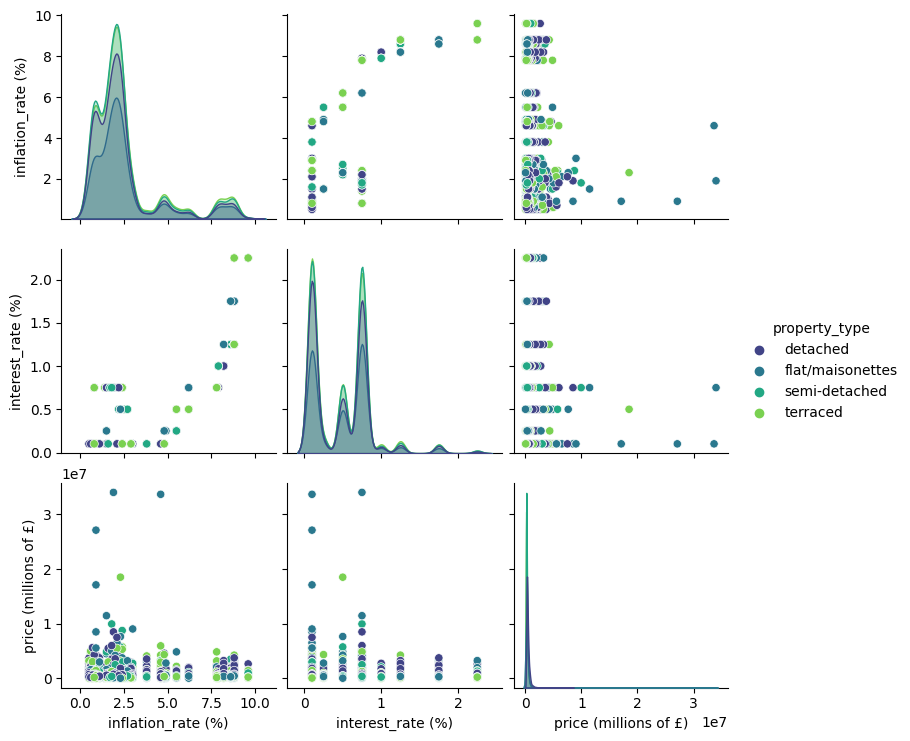

In [20]:
# plots the interaction between the continuous features
# with the `property_type` feature used for colouring the points
# and no regression line and no correlation coefficient
plot_continuous_features_interaction(
    df_1nf=df,
    hue="property_type",
    reg=False,
    corr=False,
)


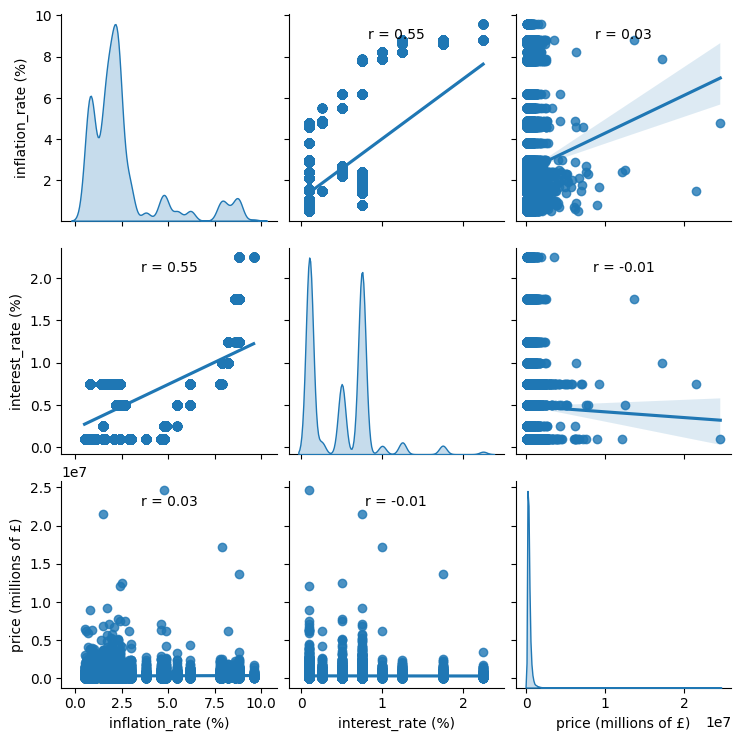

In [21]:
# plots the interaction between the continuous features
# without colouring the points
# and with a regression line and a correlation coefficient
plot_continuous_features_interaction(
    df_1nf=df,
    hue=None,
    reg=True,
    corr=True,
)


### Distribution of Inflation & Interest rates

Due to their high value, properties are often purchased with the help of credit.
And like any other product, they are subject to purchasing power of potential
buyers. These are fundamentally affected by Inflation & Interest Rates.

In this following section, we observe the distributions of rates for both,
as well as the 5%, 50% (median) and 95% percentiles, in order to determine
how often the most extreme rates appeared.


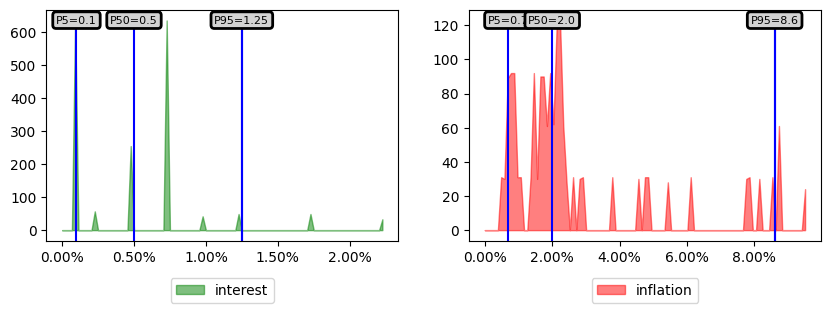

In [22]:
def plot_rate_distributions(
    ax,
    df: pd.DataFrame,
    label: str,
    color: str,
) -> None:
    """
    Plots the distribution of the `rate` feature as an area chart,
    indexed by the `label` feature, across 100 bins in the x axis.
    :param ax: the matplotlib axis to plot on
    :param df: the dataframe to plot
    :param label: the label of the plot
    :param color: the colour of the plot
    """
    # creates a copy of the dataframe to avoid modifying the original
    df = df.copy()
    # scales the `rate` feature
    df["rate"] = df["rate"] * 100.0
    # creates the bins for the x axis
    x = np.linspace(0.0, df["rate"].max(), 100)
    # segments the `rate` feature into bins
    df["bin"] = pd.cut(df["rate"], bins=x)
    # stores the number of points in each bin into `y`
    y = list(df.groupby("bin").count()["rate"])
    # plots the area chart with a formatter for the x axis
    ax.fill_between(x[:-1], 0.0, y, color=color, alpha=0.5)
    ax.xaxis.set_major_formatter(FormatStrFormatter("%2.2f%%"))
    # defines the intervals that will be annotated on the plot
    intervals = [0.05, 0.5, 0.95]
    # annotates the plot with the quantiles of the `rate` feature
    for interval, quantile in zip(intervals, df.rate.quantile(intervals)):
        # creates the annotation text
        percentile = f"P{int(interval*100.)}={round(quantile, 2)}"
        # creates the annotation box
        bbox = dict(boxstyle="round, pad=0.3", fc="lightgray", lw=2)
        # plots the vertical line and annotation
        ax.axvline(x=quantile, color="blue")
        ax.annotate(percentile, xy=(quantile, max(y)), bbox=bbox, ha="center", va="center", fontsize=8)
    # plots the legend
    ax.axvline(x=quantile, color="blue")
    ax.legend([label], loc="lower center", bbox_to_anchor=(0.5, -0.3))


# groups the "1NF dataframe" by year, month and day
df_daily_means = df.groupby(["date_year", "date_month", "date_day"]).mean(numeric_only=True)
# create new dataframes for the interest and inflation rates, with rate columns named simply "rate"
df_daily_means_interest = df_daily_means[["interest_rate"]].rename(columns={"interest_rate": "rate"})
df_daily_means_inflation = df_daily_means[["inflation_rate"]].rename(columns={"inflation_rate": "rate"})
# creates the subplots for the interest and inflation rates
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))
# plots the interest
plot_rate_distributions(
    ax=axes[0],
    df=df_daily_means_interest,
    label="interest",
    color="green",
)
# plots the inflation
plot_rate_distributions(
    ax=axes[1],
    df=df_daily_means_inflation,
    label="inflation",
    color="red",
)


### Price, Interest & Inflation in the Time-domain

The following section plots how the **Interest Rate**, the **Inflation Rate**
and the **Price** evolve over time. With that approach, if these variables are
strongly connected, it should be possible to observe they influencing one another.


100%|██████████| 4/4 [00:00<00:00, 28.73it/s]


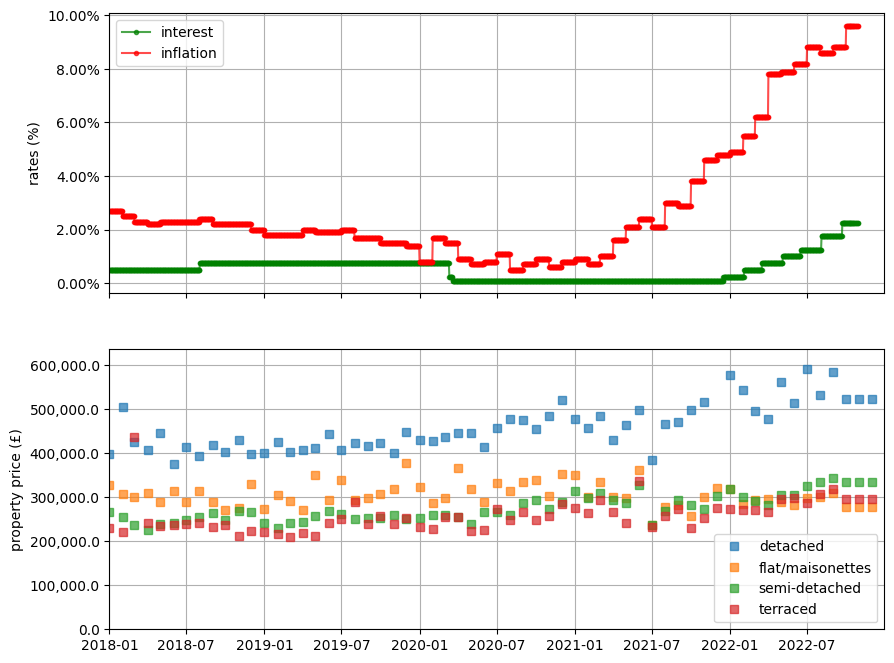

In [23]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import date


def plot_inflation_and_interest(
    ax: plt.Axes,
    df_mean_by_date: pd.DataFrame,
    xlim_left: float,
    xlim_right: float,
) -> None:
    """
    Plots the inflation and interest rates as a line chart.
    :param ax: the matplotlib axis to plot on
    :param df_mean_by_date: the 1NF dataframe grouped by date
    :param xlim_left: the left limit of the x axis
    :param xlim_right: the right limit of the x axis
    :return: None
    """
    # resets the index of the dataframe, so the "date" columns become columns
    df_mean_by_date = df_mean_by_date.reset_index()
    # creates the x axis by combining year/month/day into a single date component
    x = df_mean_by_date.apply(lambda r: date(int(r.date_year), int(r.date_month), int(r.date_day)), axis=1)
    # turns on the grid for the plot
    ax.grid(visible=True)
    # plots the interest and inflation rates, with 70% transparency
    ax.plot(x, df_mean_by_date.interest_rate * 100.0, "g.-", alpha=0.7)
    ax.plot(x, df_mean_by_date.inflation_rate * 100.0, "r.-", alpha=0.7)
    # sets the x axis limits
    ax.set_xlim(left=xlim_left, right=xlim_right)
    # sets the y axis label to "rate (%)" with a formatter for the y axis
    ax.set_ylabel("rates (%)")
    ax.yaxis.set_major_formatter(FormatStrFormatter("%2.2f%%"))
    # plots the legend
    ax.legend(["interest", "inflation"])


def plot_prices_and_rates_over_time_domain(
    ax: plt.Axes,
    df_mean_by_date_and_pt: pd.DataFrame,
) -> None:
    """
    Plots the property prices and interest/inflation rates over time.
    :param ax: the matplotlib axis to plot on
    :param df_mean_by_date_and_pt: the 1NF dataframe grouped by date and property type
    :return: None
    """
    # resets the index of the dataframe, so the "date" columns become columns
    df_mean_by_date_and_pt = df_mean_by_date_and_pt.reset_index()
    # turns on the grid for the plot
    ax.grid(visible=True)
    # formats the axis with a thousands separator and no decimal point
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,}"))
    # sets the y axis limits to 120% of the 95th percentile of the property prices
    # this will hide the 5% of the most expensive properties/outliers
    ax.set_ylim(0.0, df_mean_by_date_and_pt.price.quantile(0.95) * 1.2)
    # sets the y axis label to "property price (£)"
    ax.set_ylabel("property price (£)")
    # holds the property types
    property_types = sorted(df_mean_by_date_and_pt.property_type.unique())
    # plots the property prices as separate coloured markers
    for ix, property_type in tqdm(list(enumerate(property_types))):
        # creates a sub-series for the current property type
        sub_series = df_mean_by_date_and_pt[df_mean_by_date_and_pt.property_type == property_type].copy()
        # groups property values by year and month, and takes the mean
        sub_series = sub_series.reset_index().groupby(["date_year", "date_month"]).mean(numeric_only=True).reset_index()
        # fills in the missing values with the previous value
        sub_series = sub_series.fillna(method="ffill")
        # creates the x axis by combining year/month into a single date component
        x = sub_series.apply(lambda r: date(int(r.date_year), int(r.date_month), 1), axis=1)
        # plots the property prices as a scatter, with square markers, with 70% transparency
        ax.plot(x, sub_series.price, "s", alpha=0.7)
        # plots the legend
        ax.legend(property_types)


# holds the min and max intersecting dates, so we only show charts where data is available
min_intersecting_date = date(df.date_year.min(), 1, 1)
max_intersecting_date = date(df.date_year.max(), 12, 30)
# creates a figure with 2 subplots, sharing the x axis
_, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)
# plots the inflation and interest rates
plot_inflation_and_interest(
    ax=axes[0],
    df_mean_by_date=df.groupby(["date_year", "date_month", "date_day"]).mean(numeric_only=True),
    xlim_left=min_intersecting_date,
    xlim_right=max_intersecting_date,
)
# plots the property prices and interest/inflation rates
plot_prices_and_rates_over_time_domain(
    ax=axes[1],
    df_mean_by_date_and_pt=df.groupby(["date_year", "date_month", "date_day", "property_type"]).mean(numeric_only=True),
)


### Proportion of Transactions per Property Type (Flat, Semi/Detatched, Terraced), Property State (Old/New), Contract Duration (Lease or Freehold)

As previously observed, the `property_type` is a major defining feature in
regards to the property price.

The following section plots the proportion of the dataset in regards to each one
of the categorical features present: `property_type`, `old_or_new`, `duration`,
although we do not plot the proportion per `postgroup`, because of the large
number of categories it presents.


In [24]:
def plot_proportion_of_transactions_per_feature(
    df_1nf: pd.DataFrame,
    title: str,
    index_name: str,
) -> None:
    """
    Plots the proportion pie-chart of transactions per feature.
    :param df_1nf: the 1NF dataframe
    :param title: the title of the plot
    :param index_name: the name of the index to group by
    :return: None
    """
    # groups the dataframe by the index name, and counts the number of transactions
    df_prop_count_per_type = df_1nf.reset_index().groupby([index_name])[["index"]].count()
    df_prop_count_per_type = df_prop_count_per_type.rename(columns={"index": "transactions"})
    # groups the dataframe by the index name, and sums the price
    df_prop_price_sum_per_type = df_1nf.groupby([index_name])[["price"]].sum()
    df_prop_price_sum_per_type = df_prop_price_sum_per_type.rename(columns={"price": "volume (£)"})
    # concatenates the two dataframes columns, and sorts by index
    df_prop = pd.concat([df_prop_count_per_type, df_prop_price_sum_per_type], axis=1).sort_index()

    # creates a figure with 2 subplots, one for the number of transactions, and one for the volume traded
    fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
    axes[0].set_title("per number of transactions")
    axes[1].set_title("per volume traded (£)")

    # create the colour map and array of colours that will be used
    cm = plt.get_cmap("viridis")
    colors = [cm(1.0 * i / len(df_prop.index)) for i in range(len(df_prop.index))]
    # plot the pie chart showing the proportion of transactions per feature
    axes[0].pie(
        df_prop["transactions"],
        colors=colors,
        labeldistance=0.7,
        explode=0.2 * df_prop["transactions"] / df_prop["transactions"].sum(),
        shadow=True,
        autopct=lambda pct: f"{round(pct, 2)}%",
        pctdistance=0.7,
        textprops=dict(color="w"),
    )
    # plot the pie chart showing the proportion of volume traded per feature
    axes[1].pie(
        df_prop["volume (£)"],
        colors=colors,
        explode=0.2 * df_prop["volume (£)"] / df_prop["volume (£)"].sum(),
        shadow=True,
        autopct=lambda pct: f"{round(pct, 2)}%",
        pctdistance=0.7,
        textprops=dict(color="w"),
    )
    # sets the figure title
    fig.suptitle(title)
    # configures the figure as tight
    fig.tight_layout()
    # adds the legend to the figure
    fig.legend(df_prop.index, loc="lower center", bbox_to_anchor=(0.5, 0), ncols=len(df_prop_count_per_type.index))


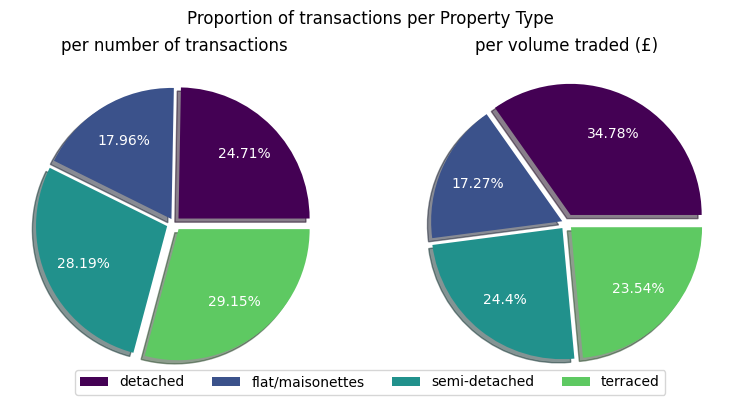

In [25]:
# plots the proportion of transactions per property type (transactions & volume £)
plot_proportion_of_transactions_per_feature(
    df_1nf=df,
    title="Proportion of transactions per Property Type",
    index_name="property_type",
)


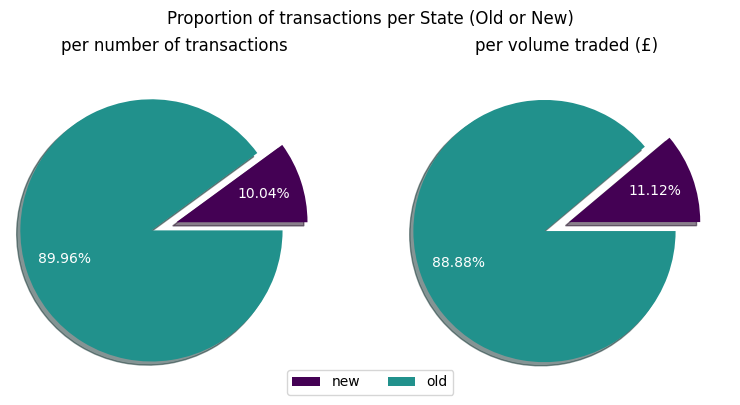

In [26]:
# plots the proportion of transactions per old/new state (transactions & volume £)
plot_proportion_of_transactions_per_feature(
    df_1nf=df,
    title="Proportion of transactions per State (Old or New)",
    index_name="old_or_new",
)


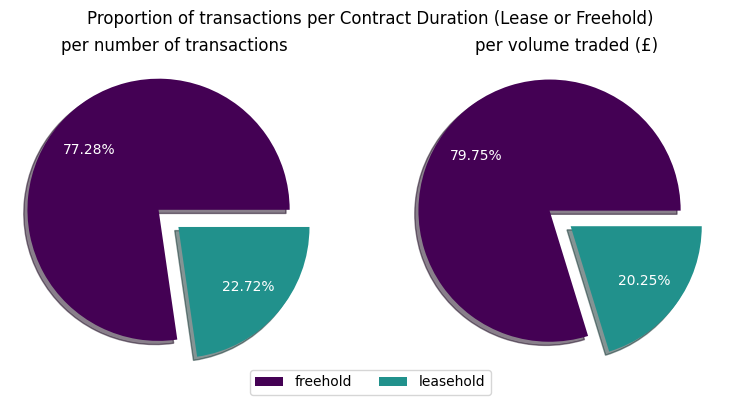

In [27]:
# plots the proportion of transactions per contract duration (transactions & volume £)
plot_proportion_of_transactions_per_feature(
    df_1nf=df,
    title="Proportion of transactions per Contract Duration (Lease or Freehold)",
    index_name="duration",
)


## Machine learning model

This section investigates our ability to regress UK property prices from
features inherent to the property itself, such as location, type and state,
and from features from the market, such as inflation and interest rates.

For the prupose of this task, two different modelling approaches will be dinvestigated.

- **Polynomial Linear Regression**: chosen due to the Occam's
  Razor[[9](#ref:web:occams-razor), the simplest model that tries to map features
  linearly to the target price. `GridSearchCV` will be used to explore the
  hyperparam search surface, exploring different polyonmial equation degrees, as
  well as the option to fit or not to fit the `y-intercept`.

- **Multi-Layer Perceptrion Regression**: inpired by the findings in literature[[4](#ref:2021:xu-et-al)]
  this approach uses a neural network, with one or more hidden layers that apply
  progressive levels of non-linear transformation on the features and tries to map
  them to the target price. `GridSearchCV` will be used to explore the different
  configurations of hidden layers, as well as solvers and alpha values for
  regularisation.

The dataset is composed by some features (e.g.: `postgroup`) which when one-hot
encoded explode into a very sparse feature vector. This poses extra-challenged
for some algorithms. **Decision Tree-based Regression** was considered, but
given that the _time-complexity_ of decision-tree based algorithms is given
by their depth, which is given by the number of features, it was not pursued.


In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# most of the experiments are stopped before convergence
# therefore we disable the convergence warnings, given that
# they don't add any extra information
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [2]:
from datetime import datetime

# sets the random_seed to be used across the experiment
r = 42

# sets the training proportion to be 99% of the 4 million records
train_size = 0.99

# sets the experiment names to which will store results in the disk
experiment_name = f"exp-20221228_1755"

# presents the settings of the experiment
(experiment_name, r, train_size)


('exp-20221228_1755', 42, 0.99)

In [3]:
import pathlib

# defines the results output dir and ensures it exists
results_dir = pathlib.Path(f"./results/{experiment_name}")
results_dir.mkdir(parents=True, exist_ok=True)

# displays the results output dir
results_dir


PosixPath('results/exp-20221228_1755')

In [4]:
# this cell is used to reload the "1NF dataframe" from the stored file
# it's used to avoid having to re-run the previous cells every time
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd
    import numpy as np

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {
            "postgroup": "category",
            "property_type": "category",
            "old_or_new": "category",
            "duration": "category",
            "price": "double",
        }
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


[SNAPSHOT] Reloading...
 - reloaded from snapshot, 4336841


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
119561,2018,2,23,4,SS12,terraced,old,freehold,0.025,0.005,"334,995.000"
1599229,2019,9,13,4,SO19,flat/maisonettes,old,leasehold,0.017,0.007,"158,000.000"
4053026,2022,4,27,2,DY9,semi-detached,old,freehold,0.078,0.007,"215,000.000"
3833547,2022,1,10,0,CH42,semi-detached,old,freehold,0.049,0.003,"229,000.000"
3835087,2022,1,11,1,L19,terraced,old,freehold,0.049,0.003,"118,000.000"


### Feature Matrix & Targets


In [5]:
# separates the features from the target
X, y = df[df.columns[:-1]], df[df.columns[-1]]

# free memory for the raw 1NF dataframe
del df


### Hold-out Test-Sets

Despite the use of `GridSearchCV` which will perform cross-validation across
the entire training split, we still keep a hold-out set of transactions to
perform a final evaluation over the best performing models found.

The following routine produces the $X1$, $y1$ regarded to as training features
and training targets, and the $X2$ and $y2$ regarded to as test features.


In [6]:
from typing import Tuple
from sklearn.model_selection import train_test_split


def produce_split_summary(
    X_split: pd.DataFrame,
    y_split: pd.DataFrame,
    name: str,
    total: int,
) -> Tuple[str, int, int, str]:
    """
    Produces a summary of the split, including the name, the
    number of rows in X and y, and the percentage of the total.
    """
    # returns the summary line
    return (
        name,
        X_split.shape[0],
        y_split.shape[0],
        "{:.1f}%".format(100.0 * X_split.shape[0] / total),
    )


# splits the data into train and test sets
X1, X2, y1, y2 = train_test_split(X, y, train_size=train_size, random_state=r)
# presents the summary of the split
print(
    pd.DataFrame(
        [
            produce_split_summary(X, y, "full", total=X1.shape[0]),
            produce_split_summary(X1, y1, "train", total=X.shape[0]),
            produce_split_summary(X2, y2, "test", total=X.shape[0]),
        ],
        columns=["split", "|X|", "|y|", "%"],
    )
)
# free memory for the original X and y
# because we now have the X1, y1, X2 and y2 splits
del X, y


   split      |X|      |y|       %
0   full  4336841  4336841  101.0%
1  train  4293472  4293472   99.0%
2   test    43369    43369    1.0%


### Model Pipeline

The $X$ feature matrix and $y$ targets array could potentially be held encoded
so that the encoding computation is saved for every experiment. However, there
are two different pipelines (**Polinomial Regression**[[11](#ref:web:sklearn-linearreg)] and **MLP Regression**[[12](#ref:web:sklearn-mlpreg)]) with different encoding requirements.
Therefore, we prepare the pipelines to work with the **1NF dataframe**, rather
than a pre-encoded version.

Our dataset is composed by more than 4 million instances, which can be considered
a fairly large dataset. Additionally One-hot encoding categorical features from
$X$ causes an explosion of very sparse features. Any modeling approach requires care in dealing with this amount of data.

The **Polynomial Regression Pipeline** is not capable of dealing with so many
categorical features. This has been observed empirically. Although no scholarly
source of information has been found to confirm it, however there has been a mention
to its time complexity being $O(np^2 + p^3)$, with $p$ being the number of features[[10](#ref:2022:carlos-llosa)]. To work around this issue, `TruncateSVD`[[13](#ref:web:sklearn-truncatesvd)]
was used as a dimensionality reduction technique. It was chosen over `PCA` due
to the sparse nature of the features.

For the **MLP Regression Pipeline**, there is no requirement for dimensionality
reduction. However, for some of the experiments, an extra initial hidden layer
was included, to work as an Embeddings Layer[[14](#ref:web:keras-embedding)],
essentially capturing the sparse vector into a lower dimensional representation,
whereas a subsequent hidden layer is expected to learn some low-level relationships
of these representations.


In [7]:
from typing import Tuple
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


def make_sine_cycle_encoder(period: int = 1) -> float:
    """
    Produces a FunctionTransformer that is capable of
    normalising a range of values using the sine function,
    returning values between -1 and 1, in order to capture
    the cyclical nature of some values (e.g. months, days).
    :param period: the period of the sine function
    :return: the sine cycle encoder
    """
    # ensures the period is not zero
    assert period != 0
    # returns the sine cycle encoder
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def make_df_column_transformer(scale_non_categorical: bool = False):
    """
    Produces a ColumnTransformer capable of transforming the 1NF dataframe
    into a format that can be used by the ML models. The transformation
    may or may not include scaling of the non-categorical features
    (required by neural networks, but not by linear models).
    :param scale_non_categorical: whether to scale the non-categorical features
    :return: the column transformer
    """
    # defines the column selector for categorical features
    categorical_selector = make_column_selector(dtype_include="category")
    # defines the column selector for non-categorical features
    non_categorical_selector = make_column_selector(dtype_exclude="category")
    # creates a one-hot encoder that is setup to ignore records with unknown values
    one_hot = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
    # creates the sine cycle encoders for the months, days and day of week
    cycle_sine_12 = make_sine_cycle_encoder(period=12)
    cycle_sine_31 = make_sine_cycle_encoder(period=31)
    cycle_sine_6 = make_sine_cycle_encoder(period=6)
    # creates the steps column transformer
    steps = [
        (one_hot, categorical_selector),
        (cycle_sine_12, ["date_month"]),
        (cycle_sine_31, ["date_day"]),
        (cycle_sine_6, ["date_day_of_week"]),
    ]
    # adds the scaler if required
    if scale_non_categorical:
        scaler = StandardScaler(with_mean=True, with_std=True)
        steps.append((scaler, non_categorical_selector))
    # returns the column transformer
    return make_column_transformer(*steps, remainder="passthrough")


def make_svd_polynomial_regression_model(
    random_state: int,
    svd_dims: int = 1,
    polynomial_degree: int = 1,
    fit_intercept: bool = False,
    verbose: bool = False,
):
    """
    Produces a pipeline that performs the following steps:
    - transforms the 1NF dataframe into a format that can be used by the ML models
    - performs dimensionality reduction using SVD
    - performs polynomial expansion
    - fits a linear regression model
    :param random_state: the random state
    :param svd_dims: the number of dimensions to reduce to
    :param polynomial_degree: the degree of the polynomial expansion
    :param fit_intercept: whether to fit an intercept
    :param verbose: whether to print the pipeline steps
    :return: the pipeline
    """
    # creates and returns the pipeline with the sequence of steps
    return make_pipeline(
        make_df_column_transformer(),
        TruncatedSVD(n_components=svd_dims, algorithm="arpack", random_state=r),
        PolynomialFeatures(degree=polynomial_degree, include_bias=False),
        LinearRegression(fit_intercept=fit_intercept),
        verbose=verbose,
    )


def make_mlp_regression_model(
    random_state: int,
    embedding_layer_dims: int = None,
    residual_layer_dims: int = 1,
    solver: str = "adam",
    alpha: float = 0.0001,
    max_iter: int = 1,
    verbose: bool = False,
):
    """
    Produces a pipeline that performs the following steps:
    - transforms the 1NF dataframe into a format that can be used by the ML models
    - fits a multi-layer perceptron regression model
    :param random_state: the random state
    :param embedding_layer_dims: the number of dimensions to reduce to
    :param residual_layer_dims: the number of dimensions to reduce to
    :param verbose: whether to print the pipeline steps
    :return: the pipeline
    """
    # holds the hidden layer sizes
    hidden_layer_sizes = []
    # if the embedding layer is required, adds it to the hidden layer sizes
    if embedding_layer_dims:
        hidden_layer_sizes.append(embedding_layer_dims)
    # if the residual layer is required, adds it to the hidden layer sizes
    # by default we have at least one residual layer
    if residual_layer_dims:
        hidden_layer_sizes.append(residual_layer_dims)
    # creates and returns the pipeline with the sequence of steps
    # the MLPRegressor is set with some defaults
    return make_pipeline(
        make_df_column_transformer(scale_non_categorical=True),
        MLPRegressor(
            hidden_layer_sizes=tuple(hidden_layer_sizes),
            solver=solver,
            alpha=alpha,
            max_iter=max_iter,
            early_stopping=True,
            random_state=random_state,
            verbose=verbose,
        ),
        verbose=verbose,
    )


# creates mock versions of the model, for a quick pipeline construction test
models = {
    "svd_polynomial_regression": make_svd_polynomial_regression_model(random_state=r, verbose=True),
    "mlp_regression": make_mlp_regression_model(random_state=r, verbose=True),
}

# fits the models and prints the metrics
# this step works with default configurations that produces
# very small models, therefore it should _not_ be time consuming
for model_name, model_instance in models.items():
    print(f"[{model_name}]")
    model_instance.fit(X1, y1)
    y1_pred = model_instance.predict(X1)
    y2_pred = model_instance.predict(X2)
    model_metrics = {
        "train": {
            "mae": mean_absolute_error(y1_pred, y1),
            "mape": mean_absolute_percentage_error(y1_pred, y1),
            "r2": mean_absolute_error(y1_pred, y1),
        },
        "test": {
            "mae": mean_absolute_error(y2_pred, y2),
            "mape": mean_absolute_percentage_error(y2_pred, y2),
            "r2": mean_absolute_error(y2_pred, y2),
        },
    }
    print(pd.DataFrame.from_dict(model_metrics))
# free memory for models, metrics and predictions
del models
del model_metrics
del y1_pred, y2_pred


[svd_polynomial_regression]
[Pipeline] . (step 1 of 4) Processing columntransformer, total=  11.8s
[Pipeline] ...... (step 2 of 4) Processing truncatedsvd, total=   4.2s
[Pipeline]  (step 3 of 4) Processing polynomialfeatures, total=   0.0s
[Pipeline] .. (step 4 of 4) Processing linearregression, total=   0.2s
           train        test
mae  173,341.905 174,260.022
mape       0.545       0.548
r2   173,341.905 174,260.022
[mlp_regression]
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   9.3s
Iteration 1, loss = 131560605211.27497864
Validation score: -0.741920
[Pipeline] ...... (step 2 of 2) Processing mlpregressor, total=  23.1s
           train        test
mae  318,083.011 318,492.447
mape  16,794.989  16,816.608
r2   318,083.011 318,492.447


### GridSearch with Cross-Validation

Both models optimise for multiple hyperparameters, situation that creates
a complex search surface to be explored. To aid in that task, the `GridSearchCV`
is employed.

It is not possible to run a Grid Search across different models, because we
must define the hyperparameters that will be searched upon, therefore separate
experiments are set for each model.

This task also takes several hours to run. To ensure it's more manageable and
save checkpoints of each stage completed, experiments are broken apart further
so the combinations of different hyperparameters is constrained by some intuition.

The segregation of experiments goes as explained bellow:

- **Polynomial Regression**:
  - `canary` runs with a fraction of the data, just to ensure that the GridSearch
    is setup correctly against the model;
  - `sm` uses $3$ SVD features and $[1, 3]$ polynomial degree expansion;
  - `md` uses $[4, 6]$ SVD features and $3$ polynomial degree expansion;
  - `lg` uses $[4, 5]$ SVD features and $4$ polynomial degree expansion;

* **MLP Regression**:
  - `emb_only` uses a single hidden layer ("embeddings only") mapping directly
    to the output, ranging from $\{2, 4, 8\}$;
  - `sm` uses the following pairs of embedding and residual layers: $\{(2, 2), (2, 4)\}$;
  - `md` uses the pairs: $\{(4,4), (4,8) \}$;
  - `lg` uses the pairs $\{(8, 8), (8, 16)\}$;

_Note:_ During experimentation, it was found that for this dataset and for the
hardware available, the _Polynomial Regression_ reached its limits of size, where
neither the number of SVD features, nor the degree of polynomial expansion could
be increased further.


In [29]:
import json
import numpy as np
from datetime import datetime
from typing import List, Dict, Tuple, Any
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


def make_grid(
    model: Pipeline,
    param_grid: Dict[str, Any],
) -> GridSearchCV:
    """
    Creates a GridSearchCV instance with the given model and parameter grid
    using a default scoring function "neg_mean_absolute_percentage_error",
    5-fold cross validation and verbose output (level 3)
    :param model: the model to fit
    :param param_grid: the parameter grid to use
    :return: the GridSearchCV instance
    """
    return GridSearchCV(
        model,
        param_grid=param_grid,
        cv=5,
        scoring="neg_mean_absolute_percentage_error",
        verbose=3,
    )


def compile_best_metrics(
    grid: GridSearchCV,
    training_data: Tuple[np.array, np.array],
    test_data: Tuple[np.array, np.array],
) -> pd.DataFrame:
    """
    Compiles the best metrics dataframe for the given grid and data
    storing the "mae", "mape" and "r2" metrics for both the training and test data
    :param grid: the grid to use
    :param training_data: the training data
    :param test_data: the test data
    :return: the metrics dataframe
    """
    # extracts the training and test data
    X_train, y_true_train = training_data
    X_test, y_true_test = test_data
    # computes the predictions and store them
    y_pred_train = grid.predict(X_train)
    y_pred_test = grid.predict(X_test)
    # creates a dataframe with metrics calculated on the predictions
    return pd.DataFrame.from_dict(
        {
            "train": {
                "mae": mean_absolute_error(y_pred_train, y_true_train),
                "mape": mean_absolute_percentage_error(y_pred_train, y_true_train),
                "r2": r2_score(y_pred_train, y_true_train),
            },
            "test": {
                "mae": mean_absolute_error(y_pred_test, y_true_test),
                "mape": mean_absolute_percentage_error(y_pred_test, y_true_test),
                "r2": r2_score(y_pred_test, y_true_test),
            },
        }
    )


def compile_search_data(cv_results: Dict[str, Any]) -> pd.DataFrame:
    """
    Compiles the search data from the given cv_results
    provided by the GridSearchCV instance.
    :param cv_results: the cv_results dictionary
    :return: the search data dataframe
    """
    # creates a dataframe from the cv_results
    df_search = pd.DataFrame.from_dict(cv_results)
    # sorts the dataframe by the rank_test_score
    df_search = df_search.sort_values(by="rank_test_score").reset_index(drop=True)
    # holds the columns that will be used as keys
    df_search_cols_key = ["rank_test_score"]
    df_search_cols_key.extend([c for c in df_search.columns.tolist() if c.startswith("param_")])
    df_search_cols_key.extend(["mean_test_score", "std_test_score"])
    df_results_cols_rest = [c for c in df_search.columns.tolist() if c not in df_search_cols_key]
    # remove the params dictionary as a column
    df_results_cols_rest.remove("params")
    # returns the dataframe with the columns as keys and the rest as values
    return df_search[df_search_cols_key + df_results_cols_rest]


def export_grid_results(
    results_dir: pathlib.Path,
    experiment_name: str,
    results: List[Tuple[str, pd.DataFrame]],
) -> None:
    """
    Exports the a set of pairs of result name and result dataframe
    to the given experiment directory.
    :param results_dir: the results directory
    :param experiment_name: the experiment name
    :param results: the list of pairs of result name and result dataframe
    :return: None
    """
    # creates the experiment directory
    experiment_dir = results_dir / experiment_name
    # ensures that the directory exists
    experiment_dir.mkdir(parents=True, exist_ok=True)
    # saves the results as csv files
    for result_name, result_df in results:
        result_df.to_csv(experiment_dir / f"{result_name}.csv")


def run_grid_experiment(
    experiment: str,
    model: Pipeline,
    training_data: Tuple[np.array, np.array],
    test_data: Tuple[np.array, np.array],
    param_grid: Dict[str, Any],
    results_dir: pathlib.Path,
):
    """
    Runs a grid experiment with the given model, training and test data
    and parameter grid. The results are exported to the given results directory.
    :param experiment: the experiment name
    :param model: the model to fit
    :param training_data: the training data
    :param test_data: the test data
    :param param_grid: the parameter grid to use
    :param results_dir: the results directory
    :return: the best metrics dataframe
    """
    print(f"[{experiment}]")
    # creates the grid
    grid = make_grid(model, param_grid)
    # extracts the training data
    X_train, y_train = training_data
    # runs the grid search
    grid.fit(X_train, y_train)
    # compiles the results for the best parameters, metrics and search data
    df_best_params = pd.DataFrame.from_dict(grid.best_params_, orient="index")
    df_best_metrics = compile_best_metrics(grid, training_data, test_data)
    df_search_data = compile_search_data(grid.cv_results_)
    # exports each one of the results
    export_grid_results(
        results_dir=results_dir,
        experiment_name=experiment,
        results=[
            ("best-params", df_best_params),
            ("best-metrics", df_best_metrics),
            ("search-data", df_search_data),
        ],
    )
    # returns the best metrics dataframe
    return df_best_metrics


#### Polynomial Linear Regression


In [30]:
# constructs the model that will have its hyperparameters grid searched
model = make_svd_polynomial_regression_model(random_state=r)


In [ ]:
# runs the grid search experiment for the SVD + Polynomial Regression model
# with a small set of data and small hyperparams to ensure that the grid search
# runs without errors.
run_grid_experiment(
    experiment=f"svd_polynomial_regression_canary",
    model=model,
    training_data=(X1[0:5000], y1[0:5000]),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [1],
        "polynomialfeatures__degree": [1],
        "linearregression__fit_intercept": [False],
    },
    results_dir=results_dir,
)


/var/folders/gt/j16393sd52s3xsm_3fsd_3qr0000gn/T/ipykernel_22899/1565712382.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  training_data=(X1[0:5000], y1[0:5000]),


[svd_polynomial_regression_canary]
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.836 total time=   0.1s
[CV 2/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.892 total time=   0.0s
[CV 3/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.837 total time=   0.1s
[CV 4/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.803 total time=   0.1s
[CV 5/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.799 total time=   0.1s


,train,test
mae,"173,160.978","174,395.551"
mape,0.544,0.547
r2,"-5,048,658.856","-4,409,838.730"


In [ ]:
# runs the grid search experiment for the SVD + Polynomial Regression model
# with the full data and a slightly larger set of hyperparams.
run_grid_experiment(
    experiment=f"svd_polynomial_regression_sm",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [3],
        "polynomialfeatures__degree": [1, 2, 3],
        "linearregression__fit_intercept": [True, False],
    },
    results_dir=results_dir,
)


[svd_polynomial_regression_sm]
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-1.196 total time=  10.7s
[CV 2/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-1.551 total time=  11.9s
[CV 3/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-2.336 total time=  10.8s
[CV 4/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-0.827 total time=  11.4s
[CV 5/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-1.552 total time=  11.7s
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=2, truncatedsvd__n_components=3;, score=-1.195 total time=  15.5s
[CV 2/5] END linearregression__fit_intercept=

,train,test
mae,"171,718.854","172,698.039"
mape,0.540,0.543
r2,-169.194,-212.548


In [ ]:
# runs the grid search experiment for the SVD + Polynomial Regression model
# with the full data and a medium set of hyperparams.
run_grid_experiment(
    experiment=f"svd_polynomial_regression_md",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [4, 5, 6],
        "polynomialfeatures__degree": [3],
        "linearregression__fit_intercept": [True, False],
    },
    results_dir=results_dir,
)


[svd_polynomial_regression_md]
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-1.102 total time=  34.9s
[CV 2/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-1.471 total time=  30.9s
[CV 3/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-2.340 total time=  26.1s
[CV 4/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-0.802 total time=  22.8s
[CV 5/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-1.324 total time=  23.3s
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=5;, score=-1.127 total time=  38.8s
[CV 2/5] END linearregression__fit_intercept=

,train,test
mae,"159,951.421","161,246.722"
mape,0.509,0.514
r2,-19.009,-24.136


In [ ]:
# runs the grid search experiment for the SVD + Polynomial Regression model
# with the full data and a large set of hyperparams.
run_grid_experiment(
    experiment=f"svd_polynomial_regression_lg",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [4, 5],
        "polynomialfeatures__degree": [4],
        "linearregression__fit_intercept": [True, False],
    },
    results_dir=results_dir,
)


[svd_polynomial_regression_lg]
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-1.088 total time=  55.4s
[CV 2/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-1.449 total time=  50.3s
[CV 3/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-2.323 total time=  50.7s
[CV 4/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-0.801 total time=  48.4s
[CV 5/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-1.317 total time=  46.6s
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=5;, score=-1.105 total time= 3.1min
[CV 2/5] END linearregression__fit_intercept=

,train,test
mae,"169,389.066","170,279.231"
mape,0.532,0.535
r2,-71.545,-89.154


#### MLP Regression


In [31]:
# constructs the model that will have its hyperparameters grid searched
model = make_mlp_regression_model(random_state=r)


In [ ]:
# runs the grid search experiment for the MLP Regression model
# with the full data and only a single hidden layer of different sizes.
run_grid_experiment(
    experiment=f"mlp_regression_emb_only",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(2,), (4,), (8,)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_emb_only]
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.040 total time= 4.0min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.505 total time= 6.2min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.000 total time= 3.3min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.692 total time= 3.9min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.286 total time= 3.8min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,

,train,test
mae,"154,364.527","155,374.364"
mape,0.478,0.481
r2,-39.092,-49.907


In [ ]:
# runs the grid search experiment for the MLP Regression model
# with the full data, a small hidden layer to capture a lower dimensional
# representation of sparse features, followed by a small hidden layer to capture
# slighly higher level relationships between these representations.
run_grid_experiment(
    experiment=f"mlp_regression_sm",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(2, 2), (2, 4)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_sm]
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.684 total time= 5.4min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.637 total time= 7.2min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.893 total time= 6.9min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.308 total time= 4.4min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.792 total time= 4.4min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=

,train,test
mae,"99,549.909","100,044.293"
mape,0.328,0.327
r2,-1.541,-2.472


In [ ]:
# runs the grid search experiment for the MLP Regression model
# with the full data, a medium hidden layer to capture a lower dimensional
# representation of sparse features, followed by a medium hidden layer to capture
# slighly higher level relationships between these representations.
run_grid_experiment(
    experiment=f"mlp_regression_md",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(4, 4), (4, 8)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_sm]
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.733 total time= 9.7min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.690 total time= 9.6min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.962 total time=11.1min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.347 total time= 9.3min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.761 total time= 9.8min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=

,train,test
mae,"89,541.390","90,766.460"
mape,0.260,0.262
r2,-0.590,-1.255


In [ ]:
# runs the grid search experiment for the MLP Regression model
# with the full data, a larger hidden layer to capture a lower dimensional
# representation of sparse features, followed by a larger hidden layer to capture
# slighly higher level relationships between these representations.
run_grid_experiment(
    experiment=f"mlp_regression_lg",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(8, 8), (8, 16)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_lg]
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.598 total time=10.3min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.649 total time=11.2min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.676 total time=15.3min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.298 total time=10.2min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.744 total time=10.2min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=

,train,test
mae,"89,136.722","90,317.630"
mape,0.261,0.262
r2,-0.480,-1.075


#### Combining Results

The folowing routine combines the results of each grid search into a single
dataframe, and orders them by **Absolute MAPE**, ranging $[0\%, \inf\%]$, where
$0$ represents no percentual error in the prediction.


In [8]:
def collate_results_and_params(dir: pathlib.Path) -> pd.DataFrame:
    """
    Reads the results of all the grid search experiments and compiles
    a dataframe containing the model names ranked by the smallest error rate.
    :param dir: The directory containing the results of the grid search experiments.
    :return: A dataframe containing the model names ranked by the smallest error rate.
    """
    # holds the results of the grid search experiments
    results = []
    # finds all the best-metrics.csv files in the sub-directory
    for filepath in dir.glob("**/best-metrics.csv"):
        # the model name is the name of the parent directory
        result_item = {"model_name": filepath.parent.name}
        # reads the best-metrics.csv file
        df_metrics = pd.read_csv(filepath)
        # sets the index to the first column
        df_metrics = df_metrics.set_index(df_metrics.columns[0]).transpose()
        # adds the best params to the result item for train and test
        for metric_name in df_metrics.columns:
            result_item[f"{metric_name}/train"] = df_metrics[metric_name]["train"]
            result_item[f"{metric_name}/test"] = df_metrics[metric_name]["test"]
        results.append(result_item)
    # constructs a dataframe from the results
    results_df = pd.DataFrame(results)
    # sorts the dataframe by the smallest error rate
    results_df = results_df.sort_values(by=["mape/train", "mape/test"], ascending=[True, True])
    # resets the index, dropping the existing index in the process
    results_df = results_df.reset_index(drop=True)
    # prepares formatters for each one of the metrics
    formatters = {
        "r2": lambda x: f"{x:,.5f}",
        "mape": lambda x: f"{x*100.:.2f} %",
        "default": lambda x: f"£ {x:,.2f}",
    }
    # formats the values of the dataframe
    for metric_split in results_df.columns:
        if metric_split.endswith("/train") or metric_split.endswith("/test"):
            metric, _ = metric_split.split("/")
            formatter = formatters.get(metric, formatters["default"])
            results_df[metric_split] = results_df[metric_split].apply(formatter)
    # returns the metics dataframe
    return results_df


# compiles the results dataframe
df_results = collate_results_and_params(dir=results_dir)

# present the results compiled
# the top one model is the best performing one, with lowest error rate
# by reading the `best-params.csv` file in the directory of the model name
# shows the winning hyperparams
df_results


,model_name,mae/train,mae/test,mape/train,mape/test,r2/train,r2/test
0,mlp_regression_md,"£ 89,541.39","£ 90,766.46",26.04 %,26.17 %,-0.58986,-1.25528
1,mlp_regression_lg,"£ 89,136.72","£ 90,317.63",26.11 %,26.22 %,-0.47994,-1.07517
2,mlp_regression_sm,"£ 99,549.91","£ 100,044.29",32.77 %,32.74 %,-1.54052,-2.47195
3,mlp_regression_emb_only,"£ 154,364.53","£ 155,374.36",47.84 %,48.15 %,-39.09169,-49.90732
4,svd_polynomial_regression_md,"£ 159,951.42","£ 161,246.72",50.91 %,51.42 %,-19.00868,-24.13596
5,svd_polynomial_regression_lg,"£ 169,389.07","£ 170,279.23",53.18 %,53.50 %,-71.54486,-89.15429
6,svd_polynomial_regression_sm,"£ 171,718.85","£ 172,698.04",53.98 %,54.32 %,-169.19441,-212.54849
7,svd_polynomial_regression_canary,"£ 173,160.98","£ 174,395.55",54.36 %,54.75 %,"-5,048,658.85590","-4,409,838.73028"


In [9]:
# reads the best params for the winning model
pd.read_csv(results_dir / df_results["model_name"][0] / "best-params.csv")


,Unnamed: 0,0
0,mlpregressor__alpha,0.0001
1,mlpregressor__hidden_layer_sizes,"(4, 8)"
2,mlpregressor__max_iter,25
3,mlpregressor__solver,adam


### Validation Curve

The following routine plots the validation curve for the best model found,
so we can pin-point the maximum number of iterations


caching encoded data


fitting & evaluating: 100%|██████████| 100/100 [41:00<00:00, 24.61s/it]


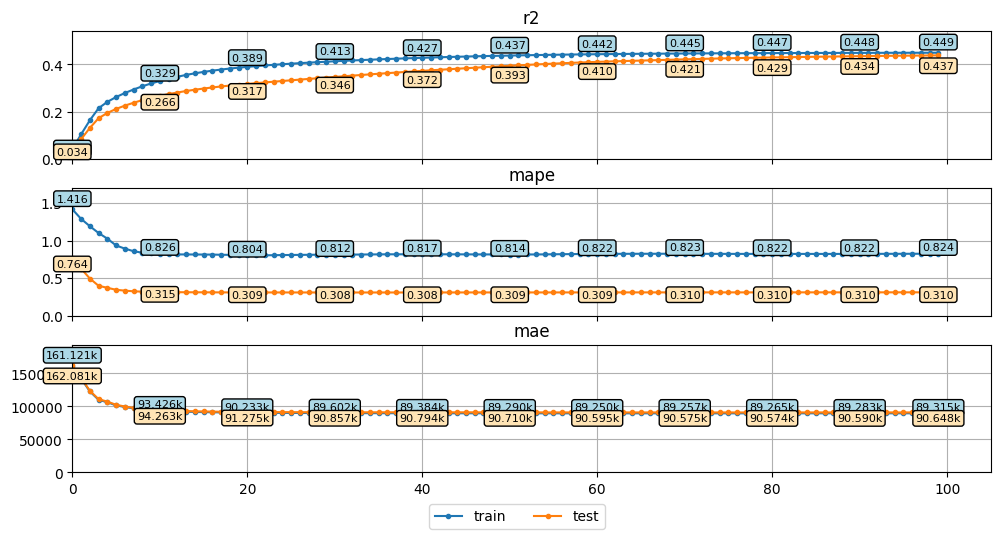

In [17]:
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error


def plot_validation_curve(
    model: Pipeline,
    training_data: Tuple[pd.DataFrame, np.ndarray],
    test_data: Tuple[pd.DataFrame, np.ndarray],
    max_iters: int,
) -> None:
    """
    Plots the validation curve for the model,
    comparing the training and test error rates,
    for all target metrics.
    :param model: The model to plot the validation curve for.
    :param training_data: The training data to use for the validation curve.
    :param test_data: The test data to use for the validation curve.
    :param max_iters: The maximum number of iterations to run the model for.
    :return: None
    """
    # hold the encoder and regressor steps of the pipeline
    _, encoder = model.steps[0]
    _, regressor = model.steps[1]
    # set the regressor to only run for 1 iteration, and to warm start
    regressor.set_params(max_iter=1, warm_start=True, verbose=False)
    print("caching encoded data")
    # cache the encoded data
    X_train_encoded, y_train = encoder.fit_transform(training_data[0]), training_data[1]
    X_test_encoded, y_test = encoder.transform(test_data[0]), test_data[1]
    # define a function to evaluate the model in terms of the metrics we care about
    y_evaluator = lambda y_pred, y_true: {
        "r2": r2_score(y_true, y_pred),
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
    }
    # hold the scores for each iteration, for both training and test
    train_scores, test_scores = [], []
    # run the model for the specified number of iterations
    for i in trange(1, max_iters + 1, desc="fitting & evaluating"):
        # fits the model; notice that because the model was setup with
        # warm start, it will not override the weights from the previous iteration
        # therefore each pass here corresponds to a new epoch/iteration
        regressor.fit(X_train_encoded, y_train)
        # appends the evaluation metrics for both train and test
        train_scores.append(y_evaluator(y_pred=regressor.predict(X_train_encoded), y_true=y_train))
        test_scores.append(y_evaluator(y_pred=regressor.predict(X_test_encoded), y_true=y_test))
    # transforms the scores into a dataframe
    train_scores_df = pd.DataFrame(train_scores)
    test_scores_df = pd.DataFrame(test_scores)
    # creates 3 row subplots to show the validation curve for each metric
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
    # configure the figure to be tight
    fig.tight_layout()
    # plots a line for train and another line for test for each metric
    skip = len(train_scores_df) // 10
    for i, metric in enumerate(["r2", "mape", "mae"]):
        ax = axs[i]
        ax.set_xlim(0, len(train_scores_df) * 1.05)
        ax.set_ylim(0.0, train_scores_df[metric].max() * 1.2)
        ax.plot(train_scores_df[metric], marker=".")
        mean_above_thousands = train_scores_df[metric].mean() > 10**3
        annotation_suffix = "k" if mean_above_thousands else ""
        for x, y in enumerate(train_scores_df[metric]):
            if x % skip == 0 or x == len(train_scores_df) - 1:
                y_text = y
                if mean_above_thousands:
                    y_text /= 10**3
                ax.annotate(
                    f"{y_text:,.3f}{annotation_suffix}",
                    xy=(x, y * 1.1),
                    ha="center",
                    va="center",
                    fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.25", fc="lightblue"),
                )
        ax.plot(test_scores_df[metric], marker=".")
        for x, y in enumerate(test_scores_df[metric]):
            if x % skip == 0 or x == len(test_scores_df) - 1:
                y_text = y
                if mean_above_thousands:
                    y_text /= 10**3
                ax.annotate(
                    f"{y_text:,.3f}{annotation_suffix}",
                    xy=(x, y * 0.9),
                    ha="center",
                    va="center",
                    fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.25", fc="moccasin"),
                )
        ax.set_title(metric)
        ax.grid(visible=True)
    fig.legend(
        ["train", "test"],
        loc="lower center",
        ncol=2,
        bbox_to_anchor=(0.5, -0.05),
    )


# plots the validation curve for the winning model
plot_validation_curve(
    model=make_mlp_regression_model(
        random_state=r,
        embedding_layer_dims=4,
        residual_layer_dims=8,
        solver="adam",
    ),
    training_data=(X1, y1),
    test_data=(X2, y2),
    max_iters=100,
)


### Learning Curve

The following routine explores the validation curve,
to see just how much training data is sufficient best for the model.


[learning_curve] Training set sizes: [1717388 2747821 3366081]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................., score=(train=-1.705, test=-0.926) total time= 5.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.7min remaining:    0.0s


[CV] END ................., score=(train=-0.853, test=-0.631) total time= 5.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.2min remaining:    0.0s


[CV] END ................., score=(train=-0.915, test=-0.694) total time=10.0min
[CV] END ................., score=(train=-1.257, test=-0.707) total time= 2.7min
[CV] END ................., score=(train=-0.872, test=-0.690) total time= 7.9min
[CV] END ................., score=(train=-0.859, test=-0.647) total time= 6.5min
[CV] END ................., score=(train=-0.739, test=-1.892) total time= 3.9min
[CV] END ................., score=(train=-0.543, test=-1.836) total time= 6.4min
[CV] END ................., score=(train=-0.608, test=-1.656) total time=11.4min
[CV] END ................., score=(train=-0.739, test=-0.350) total time= 4.1min
[CV] END ................., score=(train=-0.939, test=-0.304) total time= 9.2min
[CV] END ................., score=(train=-0.981, test=-0.306) total time=12.1min
[CV] END ................., score=(train=-0.739, test=-0.767) total time= 3.5min
[CV] END ................., score=(train=-1.046, test=-0.758) total time= 9.3min
[CV] END ................., 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 111.9min finished


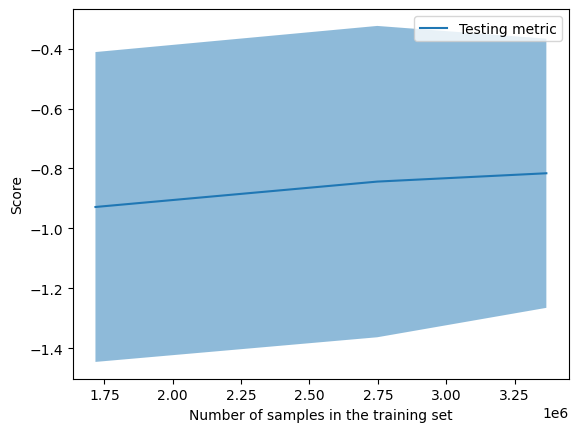

In [13]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve

# plots the learning curve for the winning model
# using the `LearningCurveDisplay` class from sklearn
# for the winning model
display = LearningCurveDisplay.from_estimator(
    make_mlp_regression_model(
        random_state=r,
        embedding_layer_dims=4,
        residual_layer_dims=8,
        max_iter=25,
        solver="adam",
    ),
    X1,
    y1,
    train_sizes=[0.5, 0.8, 0.98],
    scoring="neg_mean_absolute_percentage_error",
    verbose=3,
)


In [14]:
# constructs the winning model, fits it to the entire training data
# and presents the model pipeline visually
best_model = make_mlp_regression_model(
    random_state=r,
    embedding_layer_dims=4,
    residual_layer_dims=8,
    solver="adam",
    max_iter=25,
    verbose=True,
)
best_model.fit(X1, y1)


[Pipeline] . (step 1 of 2) Processing columntransformer, total=  13.3s
Iteration 1, loss = 99075833924.55862427
Validation score: 0.054654
Iteration 2, loss = 75835715053.43572998
Validation score: 0.135900
Iteration 3, loss = 71269842395.31101990
Validation score: 0.215141
Iteration 4, loss = 66636231968.17259979
Validation score: 0.281026
Iteration 5, loss = 63618804332.67017365
Validation score: 0.315500
Iteration 6, loss = 61835688966.82388306
Validation score: 0.341477
Iteration 7, loss = 60300741211.98292542
Validation score: 0.362790
Iteration 8, loss = 59052468595.32576752
Validation score: 0.381006
Iteration 9, loss = 57890806830.68920898
Validation score: 0.397440
Iteration 10, loss = 56869208123.53076172
Validation score: 0.411515
Iteration 11, loss = 55969325625.71036530
Validation score: 0.423652
Iteration 12, loss = 55162025784.16362000
Validation score: 0.434754
Iteration 13, loss = 54414043776.06144714
Validation score: 0.444850
Iteration 14, loss = 53720448170.56647491

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12ae5ad00>),
                                                 ('functiontransformer-1',
                                                  FunctionTransformer(func=<function make_sine_cycle_encoder.<locals>.<lambda> at 0x12a651a60>),
                                                  ['date...
                                                  FunctionTransformer(func=<function make_sine_cycle_encoder.<locals>.<lambda> at 0x12ae2dca0>),
                                                  ['date_day_of_week']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12ae5acd0>)])),
                ('mlpregressor',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(4, 8),
                              max_iter=25, random_state=42, verbose=True))],
         verbose=True)

In [15]:
# holds the predictions for X1 and X2
y1_pred = best_model.predict(X1)
y2_pred = best_model.predict(X2)
df_best_metrics = pd.DataFrame.from_dict(
    {
        "train": {
            "r2": r2_score(y1, y1_pred),
            "mae": mean_absolute_error(y1, y1_pred),
            "mape": mean_absolute_percentage_error(y1, y1_pred),
        },
        "test": {
            "r2": r2_score(y2, y2_pred),
            "mae": mean_absolute_error(y2, y2_pred),
            "mape": mean_absolute_percentage_error(y2, y2_pred),
        },
    },
    orient="index",
)
df_best_metrics


,r2,mae,mape
train,0.405,"89,541.390",0.803
test,0.405,"89,541.390",0.803


(0.0, 819500.0000000001)

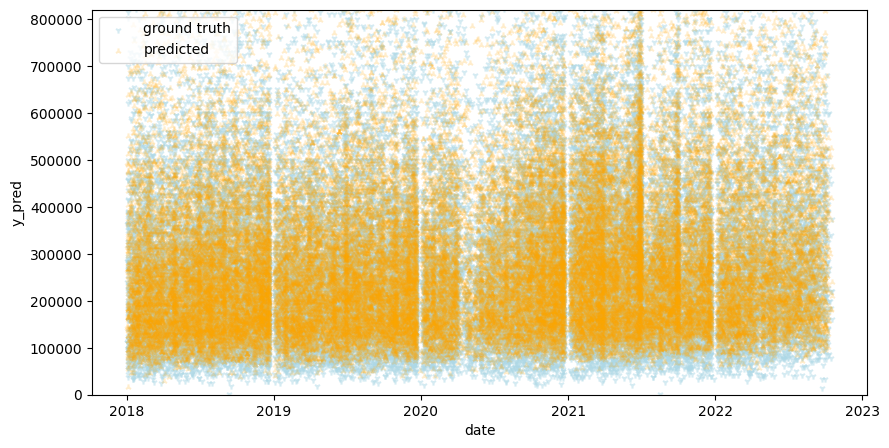

In [46]:
from datetime import date

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df_test = X2.copy()
df_test["date"] = X2.apply(lambda r: date(r["date_year"], r["date_month"], r["date_day"]), axis=1)
df_test["y_true"] = y2
df_test["y_pred"] = y2_pred
df_test = df_test[["date", "property_type", "y_true", "y_pred"]]
df_test = df_test.sort_index().reset_index(drop=True)
df_test.plot.scatter(x="date", y="y_true", ax=ax, marker='1', label="ground truth", alpha=0.5, color="lightblue")
df_test.plot.scatter(x="date", y="y_pred", ax=ax, marker='2', label="predicted", alpha=0.2, color="orange")
ax.set_ylim(0., 1.1 * df_test["y_true"].quantile(0.95))


Text(0, 0.5, 'mean(price £)')

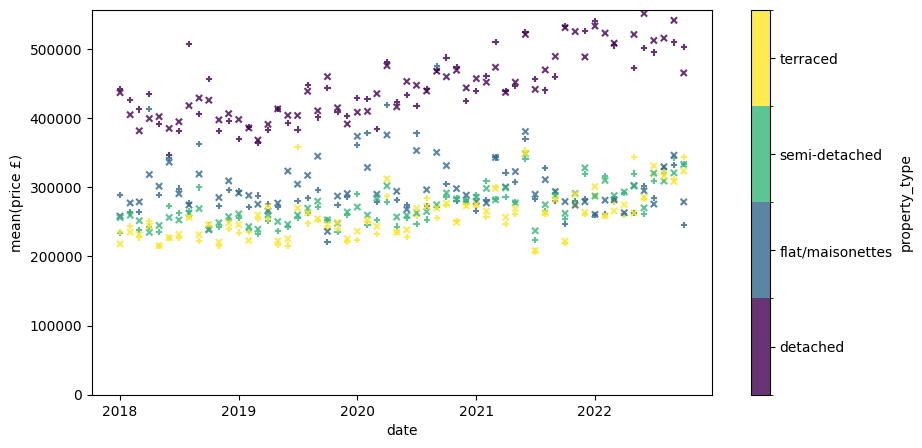

In [65]:
from datetime import date
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df_test = X2.copy()
df_test["date"] = X2.apply(lambda r: date(r["date_year"], r["date_month"], 1), axis=1)
df_test["y_true"] = y2
df_test["y_pred"] = y2_pred
df_test = df_test[["date", "property_type", "y_true", "y_pred"]]
df_test = df_test.groupby(["date", "property_type"]).mean()
df_test = df_test.sort_index().reset_index()
df_test.plot.scatter(
    x="date",
    y="y_true",
    ax=ax,
    marker="+",
    alpha=0.8,
    c="property_type",
    cmap="viridis",
)
df_test.plot.scatter(
    x="date",
    y="y_pred",
    ax=ax,
    marker="x",
    alpha=0.8,
    c="property_type",
    cmap="viridis",
    colorbar=False,
)
ax.set_ylim(0.0, 1.1 * df_test["y_true"].quantile(0.95))
ax.set_ylabel("mean(price £)")


# III. Conclusions


## Performance of results

With _Mean Absolute Percentual Error_ rate is $26.17\%$, the best model
devised was poor at best and **unlikely to be useful in any practical setting**.
The best performing one:

| model_name                         | `mlp_regression_md` |
| ---------------------------------- | :------------------ |
| mlpregressor\_\_alpha              | `0.0001`            |
| mlpregressor\_\_hidden_layer_sizes | `(4, 8)`            |
| mlpregressor\_\_solver             | `adam`              |

This is **high bias/low variance** scenario. Also, the `r2_score`
demonstrates that the input features do not explain the variance in the
outcomes at all ("worse than a horizontal line"[[15](#ref:2022:harvey-motulsky)]).


In [ ]:
df_results.iloc[[0]]


,model_name,mae/train,mae/test,mape/train,mape/test,r2/train,r2/test
0,mlp_regression_md,"£ 89,541.39","£ 90,766.46",26.04 %,26.17 %,-0.58986,-1.25528


However, the investigation did provide some relevant insights:

(1) **MLP Regression** were superior to **SVD/Polynomial Regression** in every
setting explored, which might be a consequence of prices not being linearly
mappable to any of the input features provided and ressonates with previous
findings[[4](#ref:2021:xu-et-al)];

(2) Additionally, the **best performing MLP Regression is _not_ the largest
one trained**. $(4, 8)$ hidden layers slightly outperformed larger models
(such as $(8, 8)$ and $(8, 16)$), suggesting that the former managed to capture
as many relationships as the data provides, and enlarging the model did not
provided any gains;

(3) **SVD/Polynomial Regressions** also turned out to be very limited to work
with large datasets, exploding in time-complexity for any model with SVD features
greater than $8$ or polynomial degree greater than $4$, potentially due to the
large number of instances and features[[10](#ref:2022:carlos-llosa)]. The resulting
models might not be enough to capture sufficient relationships required to
successfully map $X$ to $y$;

(4) The low `r2_score` also demonstrates that the **input features do not explain
sufficiently well the variance in the predictions**, therefore the features selected
may not be good enough to produce a successful hedonic regression model. Better
features may have to be produced, engineered and selected.

(5) The **Validation Curve** demonstrates that the **MLP Regression** training
plateaus at around 25 epochs, but keep on getting marginal gains up until 50
epochs, from where `r2_score` improves, but `MAPE` starts to drop.


## Closing remarks/statements

Although the best model still provided a _Mean Absolute Percentage Error_ rate
above 25%, it has shown potential and could be improved with follow-up experimentation.

The areas for improvement that could possibly generate a superior model, performing
at a rate of error that allows its application to commercial settings are the following:

(1) **Improve the dataset** with more continuous features, such as the number of
bedrooms: "price of houses in britain are strongly coorelated with the number
of bedrooms, number of bathrooms"[[16](#ref:2017:tyagi-siddharth)], and these
features are not present in the data. Enriching the dataset with these features
could potentially help predict property prices more accurately. However, it has
been discovered that this may result in any hedonic regression model to suffer
from incorrect or missing data points[[1](#ref:2007:hjort-et-al)], therefore
these risks need to be taken in consideration;

(2) **Apply a `hibrid regression` modeling approach** opposed to the hedonic
regression modeling one, and model to predict the rate of change for similar
properties over fewer features, rather than regress the price from intrinsic
property and market features, or simply regress the price based on price change
itself, has been found to work better than their pure counterparts[[1](#ref:2007:hjort-et-al)].
This approach could therefore be further exploited;

(3) **Geo-spacial features** derived from the full postcode, rather than working
with postalcode area may provide us with better geographic interpolation. Postal
area captures an administrative perspective over the location, but geographical
position might have higher correlation with desireability than an administrative
component;

However, without these potential improvements, we are left with a model that
shows relatively high error rate, that limit its potential applications.


# IV. References

<a id="ref:2007:hjort-et-al"></a>
[1] Anders Hjort, Johan Pensar, Ida Scheel & Dag Einar Sommervoll (2022) 'House price prediction with gradient boosted trees under different loss functions', Journal of Property Research, 39:4, 338-364, DOI: 10.1080/09599916.2022.2070525. Source: https://www.tandfonline.com/doi/pdf/10.1080/09599916.2022.2070525

<a id="ref:2022:rastegar"></a>
[2] Rastegar, Kellie. 'Why Large Pension Funds Are Investing In Private Real Estate', Forbes, 2022. Source: https://www.forbes.com/sites/forbesbusinesscouncil/2022/02/14/why-large-pension-funds-are-investing-in-private-real-estate/?sh=2d5cd1a11e45

<a id="ref:web:rightmove-avm"></a>
[3] AVM, Automated Valuation Model Service by RightMove. Source: https://www.rightmove.co.uk/property-data/automated-valuation-model/

<a id="ref:2021:xu-et-al"></a>
[4] Xu, Xiaojie, and Yun Zhang. ‘House Price Forecasting with Neural Networks’. Intelligent Systems with Applications, vol. 12, 2021, p. 200052, https://doi.org10.1016/j.iswa.2021.200052.
Source: https://reader.elsevier.com/reader/sd/pii/S2667305321000417?token=3FC43BE0FD2A4CFD9181E501BDEAE82235A2E12119F2570BEA114D70B8C1B622FB91CB03A10C5EDB66134567FF2D49AD&originRegion=eu-west-1&originCreation=20230102163119

<a id="ref:web:uk-land-registry"></a>
[5] "Price Paid Data", Last updated
30 December 2022, HM Land Registry. Source: https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads

<a id="ref:web:uk-boe-interest"></a>
[6] "Official Bank Rate history". Bank of England, 2022. Source: https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp

<a id="ref:web:uk-ons-cpih"></a>
[7] "CPIH ANNUAL RATE 00: ALL ITEMS 2015=100", Office for National Statistics, 2022. Source: https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23

<a id="ref:2022:shaun"></a>
[8] Turney Shaun, "Pearson Correlation Coefficient (r) | Guide & Examples", Scribbr, 2022. Source: https://www.scribbr.com/statistics/pearson-correlation-coefficient

<a id="ref:web:occams-razor"></a>
[9] Duignan, Brian. "Occam’s razor". Encyclopedia Britannica, 1 Dec. 2022, https://www.britannica.com/topic/Occams-razor. Accessed 5 January 2023.

<a id="ref:2022:carlos-llosa"></a>
[10] [Llosa, Carlos](https://datascience.stackexchange.com/users/127911/carlos-llosa). "What is the Time Complexity of Linear Regression?". Data Science Stack Exchange, 2022, https://datascience.stackexchange.com/questions/35804/what-is-the-time-complexity-of-linear-regression.

<a id="ref:web:sklearn-linearreg"></a>
[11] Scikit-Learn, LinearRegression. Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

<a id="ref:web:sklearn-mlpreg"></a>
[11] Scikit-Learn, MLPRegressor. Source: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

<a id="ref:web:sklearn-truncatesvd"></a>
[13] Scikit-Learn, TruncatedSVD. Source: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

<a id="ref:web:keras-embedding"></a>
[14] Keras, Embedding. Source: https://keras.io/api/layers/core_layers/embedding/

<a id="ref:2022:harvey-motulsky"></a>
[15] Harvey Motulsky[(https://stats.stackexchange.com/users/25/harvey-motulsky)]. When Is R Squared Negative? https://stats.stackexchange.com/q/12991.

<a id="ref:2017:tyagi-siddharth"></a>
[16] Tyagi, Siddharth. "Project: Analysis of housing price in UK", 2017. Source: http://rstudio-pubs-static.s3.amazonaws.com/346113_9fd34b1fcd174039bb029f2d56ec4f43.html
